# Data Exploration

In this first notebook, we will start by exploring the data. This should give us more insights in which features are important when building our model. According to the CRISP-DM model, understanding the data is the first step to extract business value out of it. Before this step, we will also look at the existing literature and define the goal of this study.

## 1. Initialize pyspark and inspect the data

#### Initialize pyspark

In [1]:
import findspark

# initialize findspark with spark directory

#ALWAYS HAVE TO BE CHANGED 
#path = "/Users/konstantinlazarov/Desktop/Big_Data/PySpark/Week_5/spark"
#path = "/Users/Artur/spark"
path = "/Users/wouterdewitte/spark/"

findspark.init(path) 

# import pyspark
import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/06 16:16:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Import necessary packages

In [2]:
# import packages
import pyspark.sql.functions as F
import pandas as pd 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import os 
import pickle

import re
from datetime import datetime

import requests

import pytz

import pandas as pd
import numpy as np

import ast

import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

#### Import the twitter data 

In [3]:
#set this path to your path, for some reason I have an error 
#reading in all the files
path_json = ".././../data/Topic/*.json"

#### Inspect the data

In [4]:
# inspect the files
df_json = spark.read.option("multiline","true").json(path_json)

22/12/06 16:17:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# inspect the number of rows
nr_observations = df_json.count()
print(nr_observations)

3428559


In [6]:
# inspect the structure of the data
df_json.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

## 2. Inspect the individual variables of the twitter data

We will now look at all the individual variables of the twitter data. This will give us more insights which features will be useful for further analysis. We will start by analyzing the data about the tweets.

We will start with analyzing the 'Tweet Object' data. However, we first want to clarify the structure of the 'Tweet Object' data:

The Tweet object has a long list of ‘root-level’ attributes, including fundamental attributes such as id, created_at, and full_text. Tweet objects are also the ‘parent’ object to several child objects. Tweet child objects include user, entities, and extended_entities. Tweets that are geo-tagged will have a place child object.


Besides, we also want to look up the explanation of unclear variables in the data dictionary of the twitter developper platform:
https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet


Note: If a lot of null values were present, we increased the number in show() temporarily to 100 to gain more insights into the variable.

### 2.1 Contributors

As we see that contributors only exists out of null values, we will drop this value. It does not provide any value to our data.

In [7]:
# inspect the first rows of the variable
df_json.select(F.col("contributors")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("contributors").isNull()).count()\
        /nr_observations*100, " %")


+------------+
|contributors|
+------------+
|        null|
|        null|
|        null|
|        null|
|        null|
+------------+
only showing top 5 rows



Percentage of null values: 100.0  %


### 2.2 Coordinates

Definition: Nullable. Represents the geographic location of this Tweet as reported by the user or client application. The inner coordinates array is formatted as geoJSON (longitude first, then latitude)

As we see that coordinates only exists out of null values, we will drop this value. It does not provide any value to our data.

In [8]:
# inspect the first rows of the variable
df_json.select(F.col("coordinates")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("coordinates").isNull()).count()\
        /nr_observations*100, " %")

+-----------+
|coordinates|
+-----------+
|       null|
|       null|
|       null|
|       null|
|       null|
+-----------+
only showing top 5 rows



Percentage of null values: 99.8574911500721  %


### 2.3 Created at

Definition: It indicates when a tweet was created.

This variable does not contain any null values. This variable will be used for our analysis as it contains usefull information.

In [9]:
# inspect the first rows of the variable
df_json.select(F.col("created_at")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("created_at").isNull()).count()\
        /nr_observations*100, " %")

+------------------------------+
|created_at                    |
+------------------------------+
|Mon Apr 04 10:09:55 +0000 2022|
|Mon Apr 04 10:09:54 +0000 2022|
|Mon Apr 04 10:09:54 +0000 2022|
|Mon Apr 04 10:09:52 +0000 2022|
|Mon Apr 04 10:09:52 +0000 2022|
+------------------------------+
only showing top 5 rows



Percentage of null values: 0.0  %


### 2.4 Display text range

This variable does not contain any null values. It indicates how many characters of the tweet were text and how long this text section was. This variable will be used for our analysis as it contains usefull information.

In [10]:
# inspect the first rows of the variable
df_json.select(F.col("display_text_range")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("display_text_range").isNull()).count()\
        /nr_observations*100, " %")

+------------------+
|display_text_range|
+------------------+
|          [0, 139]|
|          [0, 140]|
|          [17, 87]|
|          [0, 139]|
|          [0, 139]|
+------------------+
only showing top 5 rows



Percentage of null values: 0.0  %


### 2.5 Entities

Entities provide metadata and additional contextual information about content posted on Twitter. The entities section provides arrays of common things included in Tweets: hashtags, user mentions, links, stock tickers (symbols), Twitter polls, and attached media. These arrays are convenient for developers when ingesting Tweets, since Twitter has essentially pre-processed, or pre-parsed, the text body. 

So, for entities we will look at its subvariables:

1) hashtags = Represents hashtags which have been parsed out of the Tweet text.
2) media = Represents media elements uploaded with the Tweet
3) urls = Represents URLs included in the text of a Tweet
4) user_mentions = Represents other Twitter users mentioned in the text of the Tweet
5) symbols = Represents symbols, i.e. $cashtags, included in the text of the Tweet

Each of these variables again exists out of different components. Therefore, we will look at each of these variables individually and discuss the most interesting subcomponents. Variables that are not discussed will be dropped for our analysis as we do not think they have any value.


#### 2.5.1 hashtags

The entities section will contain a hashtags array containing an object for every hashtag included in the Tweet body, and include an empty array if no hashtags are present.

Within hashtags, only the variable text could provide any value. This is the name of the hashtag. However, these all seem empty arrays.

In [11]:
# inspect the first rows of the variable
df_json.select(F.col("entities.hashtags.text")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("entities.hashtags.text")== F.array()).count()\
        /nr_observations*100, " %")



+----+
|text|
+----+
|  []|
|  []|
|  []|
|  []|
|  []|
+----+
only showing top 5 rows



Percentage of null values: 57.50905847033696  %


#### 2.5.2 Media

The entities section will contain a media array containing a single media object if any media object has been ‘attached’ to the Tweet. If no native media has been attached, there will be no media array in the entities. For the following reasons the extended_entities section should be used to process Tweet native media:
+ Media type will always indicate ‘photo’ even in cases of a video and GIF being attached to Tweet.
+ Even though up to four photos can be attached, only the first one will be listed in the entities section.

NOG AANPASSEN: It could be interesting to see whether or not a media type was used in the tweet and the effect on the reach? I have no idea yet which subvariables to include as the media type is always photo and this was the most interesting one for a predictive model. Check op deze sites de rest: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/entities



In [12]:
# inspect the first rows of the variable
df_json.select(F.col("entities.media")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("entities.media").isNull()).count()\
        /nr_observations*100, " %")

+-----+
|media|
+-----+
| null|
| null|
| null|
| null|
| null|
+-----+
only showing top 5 rows



Percentage of null values: 76.36076847445239  %


#### 2.5.3 Symbols                              

Definition: The entities section will contain a symbols array containing an object for every $cashtag included in the Tweet body, and include an empty array if no symbol is present.

It can be interesting to indicate whether or not symbols were included. However, we again see a lot of null values.

In [13]:
# inspect the first rows of the variable
df_json.select(F.col("entities.symbols")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("entities.symbols")== F.array()).count()\
        /nr_observations*100, " %")

+-------+
|symbols|
+-------+
|     []|
|     []|
|     []|
|     []|
|     []|
+-------+
only showing top 5 rows



Percentage of null values: 99.68062384226143  %


#### 2.5.4 URLS                          

Definition: The entities section will contain a urls array containing an object for every link included in the Tweet body, and include an empty array if no links are present.

Again, we could look if a url was included in the tweet or not. We see that in one 5th of the cases a url was used. I do not think it is usefull to include more specifics of this variable than just the presence of it?

In [14]:
# inspect the first rows of the variable
df_json.select(F.col("entities.urls")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("entities.urls")== F.array()).count()\
        /nr_observations*100, " %")

+----+
|urls|
+----+
|  []|
|  []|
|  []|
|  []|
|  []|
+----+
only showing top 5 rows



Percentage of null values: 78.05637878770644  %


#### 2.5.5 User mentions

The entities section will contain a user_mentions array containing an object for every user mention included in the Tweet body, and include an empty array if no user mention is present.

Again, we can look if another user is mentioned or not in the tweet

In [15]:
# inspect the first rows of the variable
df_json.select(F.col("entities.user_mentions")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("entities.user_mentions")== F.array()).count()\
        /nr_observations*100, " %")

+--------------------------------------------------------------------------------+
|user_mentions                                                                   |
+--------------------------------------------------------------------------------+
|[{4886284964, 4886284964, [3, 13], Ohmpawat ( คิดถึงBBS ), ohmpawatt}]          |
|[{296107534, 296107534, [3, 17], TRIPLE.N, mynameisnanon}]                      |
|[{755329842, 755329842, [0, 16], Trudie Bellamy 💕😻👀👩🏻‍🚀, trudiebakescake}]|
|[{4886284964, 4886284964, [3, 13], Ohmpawat ( คิดถึงBBS ), ohmpawatt}]          |
|[{4886284964, 4886284964, [3, 13], Ohmpawat ( คิดถึงBBS ), ohmpawatt}]          |
+--------------------------------------------------------------------------------+
only showing top 5 rows



Percentage of null values: 26.13663641197366  %


In [16]:
# Maybe it is an idea to look at how many times a id name is referenced in tweets?
# name = name of the referenced user
# if you use id you get the id of the referenced user
nr_times_referenced = df_json.groupBy('entities.user_mentions.name').count()
nr_times_referenced.sort(col('count').desc()).show(5, truncate = False)

+-------------------------+------+
|name                     |count |
+-------------------------+------+
|[]                       |896110|
|[E! News]                |28620 |
|[🌱 Vegan Animal Lover ⓥ]|27466 |
|[Angie KaranⓋ🌱🐾🌻🇺🇦] |27130 |
|[ANIMAL ADVOCATE  Ⓥ]     |22022 |
+-------------------------+------+
only showing top 5 rows



### 2.6 Extended entities

Use this link for the definitions and extra information:
https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/extended-entities

Extra explanation: If a Tweet contains native media (shared with the Tweet user-interface as opposed via a link to elsewhere), there will also be a extended_entities section. When it comes to any native media (photo, video, or GIF), the extended_entities is the preferred metadata source for several reasons. Currently, up to four photos can be attached to a Tweet. The entities metadata will only contain the first photo (until 2014, only one photo could be included), while the extended_entities section will include all attached photos.

With native media, another deficiency of the entities.media metadata is that the media type will always indicate ‘photo’, even in cases where the attached media is a video or animated GIF. The actual type of media is specified in the extended_entities.media[].type attribute and is set to either photo, video, or animated_gif. For these reasons, if you are working with native media, the extended_entities metadata is the way to go.

We saw around 76.3% of our tweets did not have a media object (empty array for this part). As we look at the defintions provided by twitter, it would be more usefull to examine extended entities when analyzing media data. We see that the number of null values is the same for both variables, which is what we expected.

In [17]:
# inspect the first rows of the variable
df_json.select(F.col("extended_entities.media")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("extended_entities.media").isNull()).count()\
        /nr_observations*100, " %")

+-----+
|media|
+-----+
|null |
|null |
|null |
|null |
|null |
+-----+
only showing top 5 rows



Percentage of null values: 76.36076847445239  %


It is strange that this variable consists out of null values an not empty arrays as mentioned in the structure. However, we will also inspect the media types.

Now, we will look at the types of the media as this will definitely be interesting to include in our model.

We see that it are indeed not only photos as media type. Furthermore, the number of elements in the array also indicate how many media types were added. We can easily add this to the data


In [18]:
# inspect the first rows of the variable
df_json.select(F.col("extended_entities.media.type")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("extended_entities.media.type").isNull()).count()\
        /nr_observations*100, " %")

+----+
|type|
+----+
|null|
|null|
|null|
|null|
|null|
+----+
only showing top 5 rows



Percentage of null values: 76.36076847445239  %


In [19]:
# look at the number of media elements 
df_json.select(size(F.col("extended_entities.media.type"))).show(5)

+----------------------------------+
|size(extended_entities.media.type)|
+----------------------------------+
|                                -1|
|                                -1|
|                                -1|
|                                -1|
|                                -1|
+----------------------------------+
only showing top 5 rows



### 2.7 Favorite count

Nullable. Indicates approximately how many times this Tweet has been liked by Twitter users.

Interesting variable for an analysis. However, it is weird this variable has a high amount of null values

In [20]:
# inspect the first rows of the variable
df_json.select(F.col("favorite_count")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("favorite_count") ==0).count()\
        /nr_observations*100, " %")

+--------------+
|favorite_count|
+--------------+
|             0|
|             0|
|             0|
|             0|
|             0|
+--------------+
only showing top 5 rows



Percentage of null values: 78.11229149038998  %


### 2.8 Favorited

Nullable. Indicates whether this Tweet has been liked by the authenticating user. 

We will not include this variable as it has only values of the boolean type False.

In [21]:
# inspect the first rows of the variable
df_json.select(F.col("favorited")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("favorited") == False).count()\
        /nr_observations*100, " %")

+---------+
|favorited|
+---------+
|    false|
|    false|
|    false|
|    false|
|    false|
+---------+
only showing top 5 rows



Percentage of null values: 100.0  %


### 2.9 Full_text

This variable speaks for itself. However, it is usefull to notice that some tweets have no text. Some start with the value RT, which indicates a retweet.

In [22]:
# inspect the first rows of the variable
df_json.select(F.col("full_text")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("full_text") == False).count()\
        /nr_observations*100, " %")

+--------------------+
|           full_text|
+--------------------+
|RT @ohmpawatt: เพ...|
|RT @mynameisnanon...|
|@trudiebakescake ...|
|RT @ohmpawatt: เพ...|
|RT @ohmpawatt: เพ...|
+--------------------+
only showing top 5 rows



Percentage of null values: 2.9166772396216602e-05  %


### 2.10 Geo

Definition: Deprecated. Nullable. Use the coordinates field instead. This deprecated attribute has its coordinates formatted as [lat, long], while all other Tweet geo is formatted as [long, lat].

As twitter indicates themselves not to use this variable, we will not use this variable. Besides, it also has an enormous amount of null variables.

In [23]:
# inspect the first rows of the variable
df_json.select(F.col("geo")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("geo").isNull()).count()\
        /nr_observations*100, " %")

+----+
| geo|
+----+
|null|
|null|
|null|
|null|
|null|
+----+
only showing top 5 rows



Percentage of null values: 99.8574911500721  %


### 2.11 Id, id_str

The integer representation of the unique identifier for this Tweet. This number is greater than 53 bits and some programming languages may have difficulty/silent defects in interpreting it. Using a signed 64 bit integer for storing this identifier is safe. Use id_str to fetch the identifier to be safe.

So, we will use the id_str variable to identify tweets.

### 2.12 In_reply_to_screen_name

Nullable. If the represented Tweet is a reply, this field will contain the screen name of the original Tweet’s author.

In [24]:
# inspect the first rows of the variable
df_json.select(F.col("in_reply_to_screen_name")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("in_reply_to_screen_name").isNull()).count()\
        /nr_observations*100, " %")

+-----------------------+
|in_reply_to_screen_name|
+-----------------------+
|                   null|
|                   null|
|        trudiebakescake|
|                   null|
|                   null|
+-----------------------+
only showing top 5 rows



Percentage of null values: 84.66705691808133  %


### 2.13 In_reply_to_status_id, in_reply_to_status_id_str

Nullable. If the represented Tweet is a reply, this field will contain the string representation of the original Tweet’s ID. (the tweet itself)

Before, we stated that we will use the string version of the id.

We see that around 15% of our tweets are a reply to another tweet.

In [25]:
# inspect the first rows of the variable
df_json.select(F.col("in_reply_to_status_id_str")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("in_reply_to_status_id_str").isNull()).count()\
        /nr_observations*100, " %")

+-------------------------+
|in_reply_to_status_id_str|
+-------------------------+
|                     null|
|                     null|
|      1510695567747338240|
|                     null|
|                     null|
+-------------------------+
only showing top 5 rows



Percentage of null values: 85.11123769490331  %


### 2.14 In_reply_to_user_id, in_reply_to_user_id_str

Nullable. If the represented Tweet is a reply, this field will contain the string representation of the original Tweet’s author ID. (the author of the tweet)

Before, we stated that we will use the string version of the id.

In [26]:
# inspect the first rows of the variable
df_json.select(F.col("in_reply_to_user_id_str")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("in_reply_to_user_id_str").isNull()).count()\
        /nr_observations*100, " %")

+-----------------------+
|in_reply_to_user_id_str|
+-----------------------+
|                   null|
|                   null|
|              755329842|
|                   null|
|                   null|
+-----------------------+
only showing top 5 rows



Percentage of null values: 84.66705691808133  %


### 2.15 Is_quote_status

Indicates whether this is a Quoted Tweet. 

We can see that 5.1% of the tweets are quoted.

In [27]:
# inspect the first rows of the variable
df_json.select(F.col("is_quote_status")).show(5)

# look at the perecentage of null values
print("Percentage of quoted tweets:", df_json.filter(F.col("is_quote_status") == True).count()\
        /nr_observations*100, " %")

+---------------+
|is_quote_status|
+---------------+
|           true|
|           true|
|          false|
|           true|
|           true|
+---------------+
only showing top 5 rows



Percentage of quoted tweets: 5.110222691223922  %


### 2.16 Lang


Nullable. When present, indicates a BCP 47 language identifier corresponding to the machine-detected language of the Tweet text, or und if no language could be detected.

In [28]:
# inspect the first rows of the variable
df_json.select(F.col("lang")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("lang") == 'und').count()\
        /nr_observations*100, " %")

+----+
|lang|
+----+
|  th|
|  th|
|  en|
|  th|
|  th|
+----+
only showing top 5 rows



Percentage of null values: 3.1184238042862904  %


### 2.17 Metadata

This does not contain any valauble information so it will not be included in our analysis.

In [29]:
# inspect the first rows of the variable
df_json.select(F.col("metadata")).show(5)


+------------+
|    metadata|
+------------+
|{th, recent}|
|{th, recent}|
|{en, recent}|
|{th, recent}|
|{th, recent}|
+------------+
only showing top 5 rows



### 2.18 Place

Nullable When present, indicates that the tweet is associated (but not necessarily originating from) a Place. This root level attribute also has some subvariables that we will explore so we have more information about the location of our tweets.

However, it is clear from the start that also this attribute has a lot of null values.

In [30]:
# inspect the first rows of the variable
df_json.select(F.col("place")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("place").isNull()).count()\
        /nr_observations*100, " %")

+-----+
|place|
+-----+
| null|
| null|
| null|
| null|
| null|
+-----+
only showing top 5 rows



Percentage of null values: 98.89901267558761  %


#### 2.18.1 Coordinates

A series of longitude and latitude points, defining a box which will contain the Place entity this bounding box is related to. Each point is an array in the form of [longitude, latitude]. Points are grouped into an array per bounding box.

In [31]:
# inspect the first rows of the variable
df_json.select(F.col("place.bounding_box.coordinates")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("place.bounding_box.coordinates").isNull()).count()\
        /nr_observations*100, " %")

+-----------+
|coordinates|
+-----------+
|       null|
|       null|
|       null|
|       null|
|       null|
+-----------+
only showing top 5 rows



Percentage of null values: 98.89901267558761  %


#### 2.18.2 country

Name of the country containing this place. For example: United States.

In [32]:
# inspect the first rows of the variable
df_json.select(F.col("place.country")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("place.country").isNull()).count()\
        /nr_observations*100, " %")

+-------+
|country|
+-------+
|   null|
|   null|
|   null|
|   null|
|   null|
+-------+
only showing top 5 rows



Percentage of null values: 98.89901267558761  %


#### 2.18.3 Place_type

The type of location represented by this place. For example: 'city'

In [33]:
# inspect the first rows of the variable
df_json.select(F.col("place.place_type")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("place.place_type").isNull()).count()\
        /nr_observations*100, " %")

+----------+
|place_type|
+----------+
|      null|
|      null|
|      null|
|      null|
|      null|
+----------+
only showing top 5 rows



Percentage of null values: 98.89901267558761  %


### 2.19 Possibly_sensitive

Definition: This field indicates content may be recognized as sensitive. The Tweet author can select within their own account preferences and choose “Mark media you tweet as having material that may be sensitive” so each Tweet created after has this flag set.
This may also be judged and labeled by an internal Twitter support agent.

We see that only a small percentage of the tweets is indicated as sensitive. We suppose that the null values do not contain sensitive material as well. Otherwise, this would be indicated.


In [34]:
# inspect the first rows of the variable
df_json.select(F.col("possibly_sensitive")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("possibly_sensitive").isNull()).count()\
        /nr_observations*100, " %")

print("Percentage of False values:", df_json.filter(F.col("possibly_sensitive") == False).count()\
        /nr_observations*100, " %")

print("Percentage of True values:", df_json.filter(F.col("possibly_sensitive") == True).count()\
        /nr_observations*100, " %")

+------------------+
|possibly_sensitive|
+------------------+
|              null|
|              null|
|              null|
|              null|
|              null|
+------------------+
only showing top 5 rows



Percentage of null values: 61.12407574144123  %


Percentage of False values: 37.76577856761397  %


Percentage of True values: 1.1101456909447964  %


### 2.20 Quoted_status, quoted_status_id, quoted_status_id_str

Definition: This field only surfaces when the Tweet is a quote Tweet. This attribute contains the Tweet object of the original Tweet that was quoted. 

Before, we saw that around 5% of our tweets were a quoted tweet. So, quoted_status does only contain the Tweet object for about half of them. We think that the most interesting variable for our analysis will be 'is_quote_status' as 'qouted_status' does not contain much interesting information.

Therefore, we did also not look at the ids of 'quoted_status'.

In [35]:
# inspect the first rows of the variable
df_json.select(F.col("quoted_status")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("quoted_status").isNull()).count()\
        /nr_observations*100, " %")

+-------------+
|quoted_status|
+-------------+
|         null|
|         null|
|         null|
|         null|
|         null|
+-------------+
only showing top 5 rows



Percentage of null values: 97.8707089479866  %


### 2.21 Retweet_count

Number of times this Tweet has been retweeted. This variable has no null values, although it is possible that a tweet is not retweeted.

In [36]:
# inspect the first rows of the variable
df_json.select(F.col("retweet_count")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("retweet_count").isNull()).count()\
        /nr_observations*100, " %")

+-------------+
|retweet_count|
+-------------+
|         3582|
|         3837|
|            0|
|         3582|
|         3582|
+-------------+
only showing top 5 rows



Percentage of null values: 0.0  %


### 2.22 Retweeted

Indicates whether this Tweet has been Retweeted by the authenticating user.

We see that 100% of the values are False for this variable, hence it does not contain any information for our analysis.

In [37]:
# inspect the first rows of the variable
df_json.select(F.col("retweeted")).show(5)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("retweeted")== False).count()\
        /nr_observations*100, " %")

+---------+
|retweeted|
+---------+
|    false|
|    false|
|    false|
|    false|
|    false|
+---------+
only showing top 5 rows



Percentage of null values: 100.0  %


### 2.23 Retweeted_status

Definition: This attribute contains a representation of the original Tweet that was retweeted. Note that retweets of retweets do not show representations of the intermediary retweet, but only the original Tweet. 

In [38]:
# inspect the first rows of the variable
df_json.select(F.col("retweeted_status")).show(5)

+--------------------+
|    retweeted_status|
+--------------------+
|{null, null, Mon ...|
|{null, null, Mon ...|
|                null|
|{null, null, Mon ...|
|{null, null, Mon ...|
+--------------------+
only showing top 5 rows



### 2.24 Source

Definition: Utility used to post the Tweet, as an HTML-formatted string. Tweets from the Twitter website have a source value of web.

It could be interesting to include the source of the tweet in our analysis.

In [39]:
# inspect the first rows of the variable
df_json.select(F.col("source")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("source").isNull()).count()\
        /nr_observations*100, " %")

+------------------------------------------------------------------------------------+
|source                                                                              |
+------------------------------------------------------------------------------------+
|<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>|
|<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>  |
|<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>             |
|<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>  |
|<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>  |
+------------------------------------------------------------------------------------+
only showing top 5 rows



Percentage of null values: 0.0  %


### 2.26 Truncated

Definition: Indicates whether the value of the text parameter was truncated, for example, as a result of a retweet exceeding the original Tweet text length limit of 140 characters. Truncated text will end in ellipsis, like this ... Since Twitter now rejects long Tweets vs truncating them, the large majority of Tweets will have this set to false.

This variable does not contain any information as all its values are False.

In [40]:
# inspect the first rows of the variable
df_json.select(F.col("truncated")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("truncated")== False).count()\
        /nr_observations*100, " %")

+---------+
|truncated|
+---------+
|false    |
|false    |
|false    |
|false    |
|false    |
+---------+
only showing top 5 rows



Percentage of null values: 100.0  %


### 2.27 User

The User object contains Twitter User account metadata that describes the Twitter User referenced.

This variable contains a lot of subvariables, of which we will discuss the most interesting ones.

#### 2.27.1 created_at

The UTC datetime that the user account was created on Twitter.

In [41]:
# inspect the first rows of the variable
df_json.select(F.col("user.created_at")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("user.created_at").isNull()).count()\
        /nr_observations*100, " %")

+------------------------------+
|created_at                    |
+------------------------------+
|Tue Apr 23 22:35:59 +0000 2019|
|Wed Dec 15 16:27:17 +0000 2021|
|Thu May 31 15:53:03 +0000 2012|
|Wed Jul 15 19:25:11 +0000 2020|
|Wed Dec 15 16:27:17 +0000 2021|
+------------------------------+
only showing top 5 rows



Percentage of null values: 0.0  %


#### 2.27.2 Default_profile

Definition: When true, indicates that the user has not altered the theme or background of their user profile.

We see that around 72% of the users have not altered the theme or background of their user profile.

In [42]:
# inspect the first rows of the variable
df_json.select(F.col("user.default_profile")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of default values:", df_json.filter(F.col("user.default_profile")== True).count()\
        /nr_observations*100, " %")

+---------------+
|default_profile|
+---------------+
|true           |
|true           |
|true           |
|true           |
|true           |
+---------------+
only showing top 5 rows



Percentage of default values: 71.93430242851298  %


#### 2.27.3 default_profile_image

When true, indicates that the user has not uploaded their own profile image and a default image is used instead. 

We see that only 2.7% has not installed a profile image.

In [43]:
# inspect the first rows of the variable
df_json.select(F.col("user.default_profile_image")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of default values:", df_json.filter(F.col("user.default_profile_image")== True).count()\
        /nr_observations*100, " %")

+---------------------+
|default_profile_image|
+---------------------+
|false                |
|false                |
|false                |
|false                |
|false                |
+---------------------+
only showing top 5 rows



Percentage of default values: 2.6965847751198098  %


#### 2.27.4 favourites_count

The number of Tweets this user has liked in the account’s lifetime.

In [44]:
# inspect the first rows of the variable
df_json.select(F.col("user.favourites_count")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("user.favourites_count")== 0).count()\
        /nr_observations*100, " %")

+----------------+
|favourites_count|
+----------------+
|63382           |
|8726            |
|3420            |
|15655           |
|8726            |
+----------------+
only showing top 5 rows



Percentage of null values: 4.330857366024619  %


#### 2.27.5 statuses_count

The number of Tweets (including retweets) issued by the user. We see that every user has a least made one (re)tweet.

In [45]:
# inspect the first rows of the variable
df_json.select(F.col("user.statuses_count")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("user.statuses_count")== 0).count()\
        /nr_observations*100, " %")

+--------------+
|statuses_count|
+--------------+
|16666         |
|45876         |
|3519          |
|9501          |
|45876         |
+--------------+
only showing top 5 rows



Percentage of null values: 0.0  %


#### 2.27.6 followers_count

In [46]:
# inspect the first rows of the variable
df_json.select(F.col("user.followers_count")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("user.followers_count")== 0).count()\
        /nr_observations*100, " %")

+---------------+
|followers_count|
+---------------+
|139            |
|655            |
|711            |
|236            |
|655            |
+---------------+
only showing top 5 rows



Percentage of null values: 1.2709712739375347  %


#### 2.27.7 friends_count

The number of users this account is following (AKA their “followings”).

In [47]:
# inspect the first rows of the variable
df_json.select(F.col("user.friends_count")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("user.friends_count")== 0).count()\
        /nr_observations*100, " %")

+-------------+
|friends_count|
+-------------+
|346          |
|194          |
|429          |
|187          |
|194          |
+-------------+
only showing top 5 rows



Percentage of null values: 2.4540338958728727  %


#### 2.27.8 verified

When true, indicates that the user has a verified account.

In [48]:
# inspect the first rows of the variable
df_json.select(F.col("user.verified")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of verified accounts:", df_json.filter(F.col("user.verified") == True).count()\
        /nr_observations*100, " %")

+--------+
|verified|
+--------+
|false   |
|false   |
|false   |
|false   |
|false   |
+--------+
only showing top 5 rows



Percentage of verified accounts: 1.1747792585748122  %


#### 2.27.9 listed_count

The number of public lists that this user is a member of.

In [49]:
# inspect the first rows of the variable
df_json.select(F.col("user.listed_count")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of null values:", df_json.filter(F.col("user.listed_count") == 0).count()\
        /nr_observations*100, " %")

+------------+
|listed_count|
+------------+
|9           |
|3           |
|1           |
|4           |
|3           |
+------------+
only showing top 5 rows



Percentage of null values: 35.21254847882157  %


### 2.28 withheld_copyright

When present and set to “true”, it indicates that this piece of content has been withheld due to a DMCA complaint .

The percentage of withheld tweets is almost zero in our dataset.

In [50]:
# inspect the first rows of the variable
df_json.select(F.col("withheld_copyright")).show(5, truncate = False)

# look at the perecentage of null values
print("Percentage of withheld tweets:", df_json.filter(F.col("withheld_copyright") == True).count()\
        /nr_observations*100, " %")

+------------------+
|withheld_copyright|
+------------------+
|null              |
|null              |
|null              |
|null              |
|null              |
+------------------+
only showing top 5 rows



Percentage of withheld tweets: 2.9166772396216602e-05  %


## 3. Analysis Questions


### 3.1 The volume of a brand's tweet

The first question looks at the volume of a brand's tweet. Thus, we look at the amount of tweets per brand. For this question, we need the different brands and then we count the number of tweets for each brand.

In [51]:
# First, we get a list of the different brands
list_brands = ["healthyfood",
               "healthylifestyle",
               "vegan",
               "keto",
               "ketodiet",
               "ketolifestyle",
               "veganism",
               "vegetarian"]

# Besides, we also select the relevant data for this topic.
df_json_volume = df_json.select(F.col("id_str"),
                                F.col("user.screen_name"),
                                F.col("full_text")
                                )

In [52]:
# remove duplicates and retweets
df_json_volume_filtered = df_json_volume.filter(~F.col("full_text").startswith("RT")) \
                               .drop_duplicates()

#removing spam accounts 
df_json_volume_filtered = df_json_volume_filtered.drop_duplicates(["full_text", "screen_name"])

In [53]:
# create a function to define the count per brand and plot the results
def volume_per_brand(brand):
    print(" The brand" , brand, "has a volume of",
          df_json_volume_filtered.filter(df_json_volume_filtered.full_text.contains(brand)).count(),
           "tweets.")
    
    
for brand in list_brands: 
    volume_per_brand(brand) 

 The brand healthyfood has a volume of 47011 tweets.


 The brand healthylifestyle has a volume of 52976 tweets.


 The brand vegan has a volume of 551736 tweets.


 The brand keto has a volume of 89697 tweets.


 The brand ketodiet has a volume of 9077 tweets.


 The brand ketolifestyle has a volume of 1938 tweets.


 The brand veganism has a volume of 38325 tweets.


 The brand vegetarian has a volume of 74609 tweets.


This clearly indicates that the majority of our tweets is about the topic vegan.

In [54]:
#plot aantal tweets over een topic over time 

df_json_sub = df_json.select(F.col("user.name"),
                                F.col("user.screen_name"),
                                F.col("created_at"), 
                                F.col("full_text"),  
                                F.col("user.followers_count")
                                )
#date --> time stamp variable 
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None
date_udf = F.udf(getDate, StringType())
df_json_sub = df_json_sub.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

#extract year, month, day 

df_json_sub = df_json_sub.withColumn('year', year('post_created_at'))
df_json_sub = df_json_sub.withColumn('month', month('post_created_at'))
df_json_sub = df_json_sub.withColumn('day', dayofmonth('post_created_at'))


#drop duplicates  
df_json_sub = df_json_sub.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates().cache()

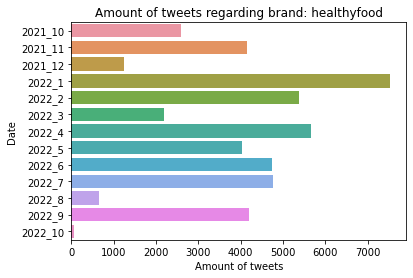

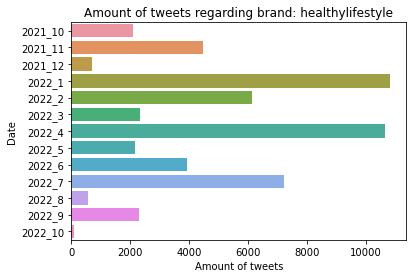

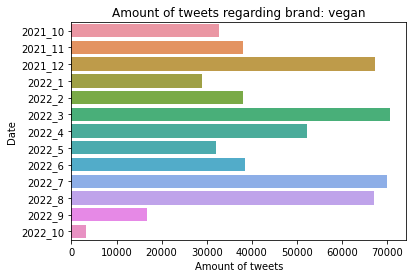

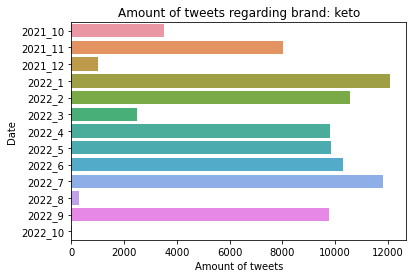

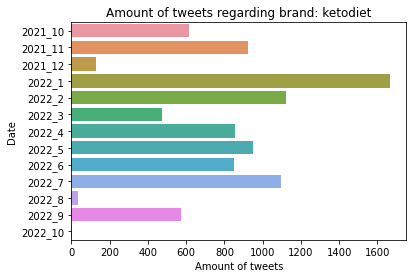

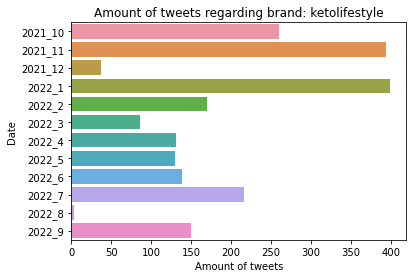

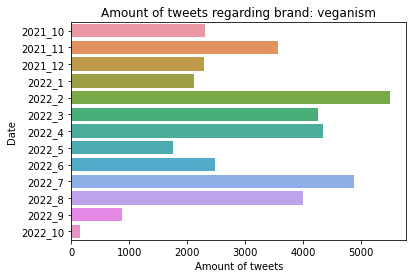

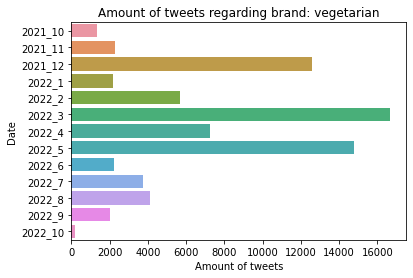

In [55]:
#give brand and graph amount of tweets per month containing brand 
def followers_over_time(brand):
    df_month = df_json_sub.filter(df_json_sub.full_text.contains(brand))
    df_month = df_month.groupBy('year', 'month').agg(countDistinct("full_text"))\
                        .withColumnRenamed("count(full_text)", "freq") \
                            .sort('year', 'month', ascending = True)
    df_month = df_month.select(concat_ws('_',df_month.year, df_month.month)\
                               .alias('date'), 'freq').toPandas()

    
    ax = sns.barplot(data=df_month, y="date", x="freq", orient = 'h')

    ax.set(title = 'Amount of tweets regarding brand: ' + brand, 
            xlabel = 'Amount of tweets', 
            ylabel = 'Date')
    plt.show()

for brand in list_brands: 
    followers_over_time(brand) 

### 3.2 The language used in the tweets (words, sensitivity, emojis...)

#### 3.2.1 Analysis the language used in the tweets

For this question, we will first look at the different languages that are being used in the tweets. This can be found in the tweet object lang. Besides, we also create a dataframe with the necessary variables for this question.

In [56]:
# Select the relevant data for this topic.
df_json_language = df_json.select(F.col("id_str"),
                                F.col("full_text"),
                                F.col("display_text_range"),
                                 F.col("entities.hashtags.text"),
                                 F.col("entities.symbols"),
                                 F.col("entities.urls"),
                                 F.col("user.screen_name"),
                                 F.col("extended_entities.media.type"),
                                 F.col("extended_entities.media"),
                                 F.col("lang"))

First, we do some preprocessing on these tweets.

In [57]:
# remove duplicates and retweets
df_json_language = df_json_language.filter(~F.col("full_text").startswith("RT")) \
                               .drop_duplicates()
#removing spam accounts 
df_json_language = df_json_language.drop_duplicates(["full_text", "screen_name"])

Look at the language of the tweets

In [58]:
# Now, we look at the language of the different tweets
df_language = df_json_language.groupBy('lang').agg(count('full_text')).withColumnRenamed("count(full_text)", "volume")\
                    .withColumnRenamed("lang", "language")

# print the number of different languages (= 62)
print('The number of different languages:', df_language.count())

# look at the 10 most common languages
df_language.sort(df_language.volume.desc()).show(10)

# we see that the majority of our tweets is in English

The number of different languages: 61


+--------+------+
|language|volume|
+--------+------+
|      en|968775|
|      es| 59035|
|      ja| 58413|
|     und| 54872|
|      de| 36869|
|      pt| 36479|
|      fr| 21467|
|      in| 16026|
|      tr| 14865|
|      nl| 11204|
+--------+------+
only showing top 10 rows



#### 3.2.2 Analysis the number of words, the emojis, the hashtags...

For the other part of this question, we will first clean and tokenize the text. Then, this can be used to calculate the number of words per tweet, the total number of hashtags per tweet...

So, let us first clean the text in the tweets: 

 1. convert the text to lower case by using F.lower() function.
 2. remove the punctuation by applying the correct UDF.
 3. tokenize the text by using the F.split() function.
 4. remove stopwords from tokenized text
 5. drop variables so that the final dataframe only contains the post id and the tokenized cleaned text.
 
To remove the punctuation in the text and to remove stop words, we first create two functions, which we register as UDF.

In [59]:
# import required packages
from string import punctuation
from nltk.corpus import stopwords

# First, we define punctuation and stopwords
PUNCTUATION = [char for char in punctuation if char not in ["!", "@", "#"]]
STOPWORDS = stopwords.words("english")

In [60]:
# define function to remove punctuation
def remove_punct(text):
    # remove punctuation
    text = "".join([char for char in text if char not in PUNCTUATION])
    return(text)

In [61]:
# define function to remove stopwords
def remove_stops(text_tokenized):
    # remove stopwords
    text_tokenized = [word for word in text_tokenized if word not in STOPWORDS]
    return(text_tokenized)

In [62]:
# register functions as udf
remove_punct_UDF = F.udf(remove_punct, StringType())
remove_stops_UDF = F.udf(remove_stops, ArrayType(StringType()))

In [63]:
# apply udfs on dataframe to cleane text and tokenize the text
# Besides, we also drop some of the created variables
df_json_language = df_json_language.withColumn("text_lower", F.lower("full_text")) \
                                         .withColumn("text_cleaned", remove_punct_UDF("text_lower")) \
                                         .withColumn("text_tokenized", F.split("text_cleaned", " ")) \
                                         .withColumn("text_tokenized_no_stops", remove_stops_UDF("text_tokenized")) \
                                         .drop("text") \
                                         .drop("text_lower") \
                                         .drop("text_cleaned") \
                                         .drop("text_tokenized")

We now define a function that counts the number of words that contain a hashtag in a given lsit of tokens. Besides, we also define a function that counts the number of words that contain a tag in a given list of tokens and define an emoji counter. They are all registered as an udf.

To calculate the number of words, we just use the function F.size()

In [64]:
import emojis
# define function to count hashtags
def get_hashtags(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "#" in word:
            counter += 1
    return(counter)

# define function to count hashtags
def get_tags(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "@" in word:
            counter += 1
    return(counter)

def emoji_counter(text):
    nr_emojis = emojis.count(text)
    return(nr_emojis)

# register as udfs
get_hashtags_udf = F.udf(get_hashtags, IntegerType())
get_tags_udf = F.udf(get_tags, IntegerType())
emoji_counter_udf = F.udf(emoji_counter, IntegerType())

In [65]:
# Create number of words, number of hashtags and number of tags per tweet
df_tokenized = df_json_language.withColumn("num_words", F.size("text_tokenized_no_stops")) \
                                         .withColumn("num_hashtags", get_hashtags_udf("text_tokenized_no_stops")) \
                                         .withColumn("num_tags", get_tags_udf("text_tokenized_no_stops"))\
                                         .withColumn("emoji_count", emoji_counter_udf("full_text"))\
                                         .drop('display_text_range')\
                                         .drop('symbols')\
                                         .drop('urls')\
                                         .drop('type')\
                                         .drop('full_text')\
                                         .drop('id_str')\
                                         .drop('media')\
                                         .drop('lang')

In [66]:
# inspect the data
df_tokenized.show(5)

+---------------+-----------------------+---------+------------+--------+-----------+
|    screen_name|text_tokenized_no_stops|num_words|num_hashtags|num_tags|emoji_count|
+---------------+-----------------------+---------+------------+--------+-----------+
|    UzairEssack|   [smoothie, boxes,...|       25|           0|       0|          0|
|    cryptobug06|   [@anvaranu374, @c...|       29|           0|       3|          8|
|     505stories|   [collection, blur...|       12|           0|       0|          0|
|HealthmnsWealth|   [✏️, moroccan, ol...|       34|           0|       0|          7|
| Harshu79221706|   [lemon, mojito, t...|       35|           7|       1|          0|
+---------------+-----------------------+---------+------------+--------+-----------+
only showing top 5 rows



In [67]:
# look at the percentage of tweets with no tokens:
print("Percentage of tweets with no tokens:", df_tokenized.filter(F.col("num_words") == 0).count()\
        /df_tokenized.count()*100, " %")

Percentage of tweets with no tokens: 0.0004474479804435403  %


Further, we also already looked at the percentage of tweets that contain an emoji, a hashtag, a symbol, urls or media content in the first part of the data exploration.

Next, we look at the sensitivity of our data.

#### 3.2.3 Analysis the sensitivity of the tweets


This part will be covered in the sentiment analysis of our tweets.

### 3.3 The timing of tweets posted by a brand

In [68]:
# Select the relevant data
df_timing = df_json.select(F.col("created_at"),
                           F.col("user.screen_name"),
                           F.col("full_text"))

In [69]:
# remove duplicates and retweets
df_timing = df_timing.filter(~F.col("full_text").startswith("RT")) \
                               .drop_duplicates() \
                               .cache()
#removing spam accounts 
df_timing = df_timing.drop_duplicates(["full_text", "screen_name"])
                        

In [70]:
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df_timing = df_timing.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

#### Look at the number of tweets per hour

In [71]:
# look at the number of tweets per hour
df_timing_hour = df_timing.withColumn("hour", hour(df_timing["post_created_at"]))
df_timing_hour = df_timing_hour.groupBy('hour').agg(countDistinct("full_text"))\
            .withColumnRenamed("count(full_text)", "volume") \
            .sort('hour', ascending = True).toPandas()
df_timing_hour.head(5)

22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:27:19 WARN RowBasedKeyValueBatch: Calling spill() on

,hour,volume
0,0,46826
1,1,46533
2,2,42314
3,3,39975
4,4,38116


In [72]:
import plotly
import plotly.express as px
# plot the number of tweets per hour
fig = px.line(df_timing_hour, x = 'hour', y= 'volume')

# Add figure title
fig.update_layout(
title_text="Tweet Activity Hourly",
title_x = 0.5
    )

# add axes
fig.update_xaxes(title_text="<b>Hour</b>")
fig.update_yaxes(title_text="<b>Amount of tweets</b>")

fig.show()

#### Look at the number of tweets per day of the week

In [73]:
def dayToInt(dayOfWeek):
    if(dayOfWeek == "Mon"):
        return 1
    if(dayOfWeek == "Tue"):
        return 2
    if(dayOfWeek == "Wed"):
        return 3
    if(dayOfWeek == "Thu"):
        return 4
    if(dayOfWeek == "Fri"):
        return 5
    if(dayOfWeek == "Sat"):
        return 6
    if(dayOfWeek == "Sun"):
        return 7

day_to_integer = F.udf(dayToInt, StringType())

In [74]:
# look at the number of tweets per hour
df_timing_day = df_timing.withColumn("week_day", date_format(col("post_created_at"), "E"))
df_timing_day = df_timing_day.groupBy("week_day").agg(countDistinct("full_text"))\
            .withColumnRenamed("count(full_text)", "volume") \
            .withColumn("week_day_int", day_to_integer("week_day"))\
            .sort('week_day_int', ascending = True).toPandas()
df_timing_day.head(5)

22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:28:17 WARN RowBasedKeyValueBatch: Calling spill() on

,week_day,volume,week_day_int
0,Mon,199292,1
1,Tue,225963,2
2,Wed,199262,3
3,Thu,177547,4
4,Fri,184651,5


In [76]:
import plotly
import plotly.express as px
# plot the number of tweets per weekday
fig = px.line(df_timing_day, x = 'week_day', y= 'volume')

# Add figure title
fig.update_layout(
title_text="Tweet Activity per weekday",
title_x = 0.5
    )

# add axes
fig.update_xaxes(title_text="<b>weekday</b>")
fig.update_yaxes(title_text="<b>Amount of tweets</b>")

fig.show()

#### Look at the number of tweets per day of the month

In [77]:
# look at the number of tweets per hour
df_timing_day_month = df_timing.withColumn("day_month", date_format(col("post_created_at"), "d"))
df_timing_day_month = df_timing_day_month.groupBy("day_month").agg(countDistinct("full_text"))\
            .withColumnRenamed("count(full_text)", "volume") \
            .withColumn("day_month", df_timing_day_month["day_month"].cast('int'))\
            .sort('day_month', ascending = True).toPandas()
df_timing_day_month.head(5)

22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:32:02 WARN RowBasedKeyValueBatch: Calling spill() on

,day_month,volume
0,1,69883
1,2,53393
2,3,50568
3,4,55076
4,5,58959


In [78]:
import plotly
import plotly.express as px
# plot the number of tweets per day of the month
fig = px.line(df_timing_day_month, x = 'day_month', y= 'volume')

# Add figure title
fig.update_layout(
title_text="Tweet Activity per weekday",
title_x = 0.5
    )

# add axes
fig.update_xaxes(title_text="<b>day of the month</b>")
fig.update_yaxes(title_text="<b>Amount of tweets</b>")

fig.show()

#### Look at the number of tweets per month

In [32]:
# look at the number of tweets per hour
df_timing_month = df_timing.withColumn("month", date_format(col("post_created_at"), "M"))
df_timing_month = df_timing_month.groupBy("month").agg(countDistinct("full_text"))\
            .withColumnRenamed("count(full_text)", "volume") \
            .withColumn("month", df_timing_month["month"].cast('int'))\
            .sort('month', ascending = True).toPandas()
df_timing_month.head(5)

22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 08:00:23 WARN RowBasedKeyValueBatch: Calling spill() on

,month,volume
0,1,80091
1,2,147749
2,3,126902
3,4,136172
4,5,90135


In [33]:
import plotly
import plotly.express as px
# plot the number of tweets per day of the month
fig = px.line(df_timing_month, x = 'month', y= 'volume')

# Add figure title
fig.update_layout(
title_text="Tweet Activity per month",
title_x = 0.5
    )

# add axes
fig.update_xaxes(title_text="<b>month of the year</b>")
fig.update_yaxes(title_text="<b>Amount of tweets</b>")

fig.show()

These were just a few examples of the timing of the tweets. We can also choose other categories based on the minute, seconds, quarter... via this website:
https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html


### 3.4 The number of followers of the brand

 Most of these regular posters for these 'brands' (different food trends) are independant vloggers/bloggers with a few thousand followers.

In [79]:
def info_brands(brand): 
    #filter the tweets in which these healthyfood are mentioned 
    df_healthy_food = df_json_sub.filter(df_json_sub.full_text.contains(brand))
    #group by name 
    df_healthy_food = df_healthy_food.groupBy('name', 'screen_name')\
                                .agg(max('followers_count'), countDistinct('full_text'))\
                                .withColumnRenamed('max(followers_count)', 'amount_of_followers')\
                                .withColumnRenamed('count(full_text)', 'count_of_tweets') 
    #calculating weight variable 
    df_healthy_food = df_healthy_food.withColumn('weight', 
                                                 (df_healthy_food['amount_of_followers']*df_healthy_food['count_of_tweets']))
    
    #sort the based on the amount of followers of the user 
    print('Account with the highest amount of followers tweeting about: ' + brand)
    df_healthy_food.sort(df_healthy_food.amount_of_followers.desc()).show(5)
    
    #sort the based on the amount of tweets  
    print('Account with the highest amount of tweets tweeting about: ' + brand)
    df_healthy_food.sort(df_healthy_food.count_of_tweets.desc()).show(5)
    
    
    #sort based on the weight 
    print('Account with the heighest weight: ' + brand)
    df_healthy_food.sort(df_healthy_food.weight.desc()).show(5) 
    
    
    #only show accounts with at least 50 tweets 
    df_healthy_food_50  = df_healthy_food.filter(df_healthy_food.count_of_tweets>50)\
                                        .sort(df_healthy_food.weight.desc()) 
    print('Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: ' + brand)
    df_healthy_food_50.show(5)
    
    #printing for the top engager when the account tweeted regarding the topic 
    top = df_healthy_food_50.select('screen_name').collect()[0][0]
    df_top = df_json_sub.filter(df_json_sub.screen_name == top) #selecting the user
    df_top = df_top.filter(df_top.full_text.contains(brand)) #selecting the brand 
    df_top = df_top.groupBy('year', 'month').agg(countDistinct("full_text"))\
                        .withColumnRenamed("count(full_text)", "freq") \
                            .sort('year', 'month', ascending = True)
    df_top = df_top.select(concat_ws('_',df_top.year, df_top.month)\
                               .alias('date'), 'freq').toPandas()
    ax = sns.barplot(data=df_top, y="date", x="freq", orient = 'h')

    ax.set(title = 'Amount of tweets regarding brand: ' + brand +',  from user ' + top , 
            xlabel = 'Amount of tweets', 
            ylabel = 'Date')
    plt.show()

Account with the highest amount of followers tweeting about: healthyfood


+--------------------+--------------+-------------------+---------------+-------+
|                name|   screen_name|amount_of_followers|count_of_tweets| weight|
+--------------------+--------------+-------------------+---------------+-------+
|             @zoomtv|        ZoomTV|            4600140|              1|4600140|
|                Yara|       yara_lb|            4188502|              1|4188502|
|         Kunal Kapur|ChefKunalKapur|            2086031|              2|4172062|
|         News7 Tamil|    news7tamil|            2016412|              3|6049236|
|PuthiyathalaimuraiTV|PTTVOnlineNews|            1902786|              4|7611144|
+--------------------+--------------+-------------------+---------------+-------+
only showing top 5 rows

Account with the highest amount of tweets tweeting about: healthyfood


+--------------------+---------------+-------------------+---------------+------+
|                name|    screen_name|amount_of_followers|count_of_tweets|weight|
+--------------------+---------------+-------------------+---------------+------+
|        Spice Jungle|   SpiceJungle1|                441|           1109|489069|
|  Subhash chand jain|Subhash52820845|                544|            935|508640|
|        Neels Kumari|    KumariNeels|                300|            689|206700|
|aedificatio scientia|   AedinInsight|                 66|            545| 35970|
|      Choshi Yoshizo|  choshiyoshizo|                591|            540|319140|
+--------------------+---------------+-------------------+---------------+------+
only showing top 5 rows

Account with the heighest weight: healthyfood


+-------------------+---------------+-------------------+---------------+--------+
|               name|    screen_name|amount_of_followers|count_of_tweets|  weight|
+-------------------+---------------+-------------------+---------------+--------+
|  Chantel Martiromo|  _Woman_health|             389748|            176|68595648|
|     Kyle J. Norton|    kylejnorton|             347633|            178|61878674|
|The Curable Recipes|CurableSmoothie|             355601|            128|45516928|
|    Angela J. White|  50Plushealths|             308976|            108|33369408|
|     Tracey Edmonds| Traceyeedmonds|             113636|            134|15227224|
+-------------------+---------------+-------------------+---------------+--------+
only showing top 5 rows

Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: healthyfood


+-------------------+---------------+-------------------+---------------+--------+
|               name|    screen_name|amount_of_followers|count_of_tweets|  weight|
+-------------------+---------------+-------------------+---------------+--------+
|  Chantel Martiromo|  _Woman_health|             389748|            176|68595648|
|     Kyle J. Norton|    kylejnorton|             347633|            178|61878674|
|The Curable Recipes|CurableSmoothie|             355601|            128|45516928|
|    Angela J. White|  50Plushealths|             308976|            108|33369408|
|     Tracey Edmonds| Traceyeedmonds|             113636|            134|15227224|
+-------------------+---------------+-------------------+---------------+--------+
only showing top 5 rows



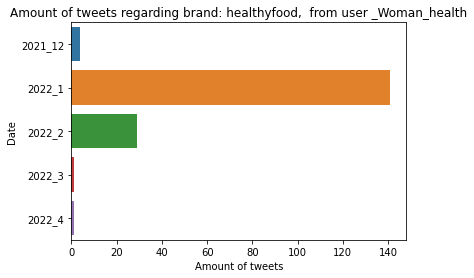

Account with the highest amount of followers tweeting about: healthylifestyle


+--------------------+---------------+-------------------+---------------+--------+
|                name|    screen_name|amount_of_followers|count_of_tweets|  weight|
+--------------------+---------------+-------------------+---------------+--------+
|SHILPA SHETTY KUNDRA|TheShilpaShetty|            6459016|              3|19377048|
|     Sebastian Rulli| sebastianrulli|            2918439|              1| 2918439|
|                 DNA|            dna|            2282085|              6|13692510|
|            DawnNews|      Dawn_News|            2189518|              3| 6568554|
|            India TV|    indiatvnews|            2064560|              7|14451920|
+--------------------+---------------+-------------------+---------------+--------+
only showing top 5 rows

Account with the highest amount of tweets tweeting about: healthylifestyle


+--------------------+---------------+-------------------+---------------+--------+
|                name|    screen_name|amount_of_followers|count_of_tweets|  weight|
+--------------------+---------------+-------------------+---------------+--------+
|www.amora-shoppin...|  AmoraShopping|                186|           1123|  208878|
|   Ranjan Kumar Sahu|  Author_Ranjan|              10709|            934|10002206|
|aedificatio scientia|   AedinInsight|                 66|            545|   35970|
|            PVAngels|   pvTeamAngels|               1197|            317|  379449|
|       _weight_loss_|weightl30407944|                 10|            312|    3120|
+--------------------+---------------+-------------------+---------------+--------+
only showing top 5 rows

Account with the heighest weight: healthylifestyle


+--------------------+---------------+-------------------+---------------+--------+
|                name|    screen_name|amount_of_followers|count_of_tweets|  weight|
+--------------------+---------------+-------------------+---------------+--------+
|SHILPA SHETTY KUNDRA|TheShilpaShetty|            6459016|              3|19377048|
|            India TV|    indiatvnews|            2064560|              7|14451920|
|                 DNA|            dna|            2282085|              6|13692510|
| Anandabazar Patrika|  MyAnandaBazar|             418018|             32|13376576|
|   Ranjan Kumar Sahu|  Author_Ranjan|              10709|            934|10002206|
+--------------------+---------------+-------------------+---------------+--------+
only showing top 5 rows

Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: healthylifestyle


+--------------------+---------------+-------------------+---------------+--------+
|                name|    screen_name|amount_of_followers|count_of_tweets|  weight|
+--------------------+---------------+-------------------+---------------+--------+
|   Ranjan Kumar Sahu|  Author_Ranjan|              10709|            934|10002206|
|Metro Manila Chir...|     DrKimKhauv|              89260|             97| 8658220|
|         Danette May| DanetteFitness|             126204|             56| 7067424|
|    Tribun Pontianak|tribunpontianak|              90975|             61| 5549475|
|      Raymond Norman| Raymond_Norman|              52776|             55| 2902680|
+--------------------+---------------+-------------------+---------------+--------+
only showing top 5 rows



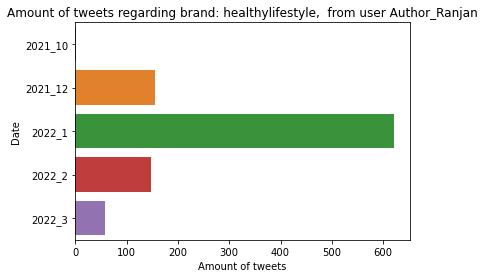

Account with the highest amount of followers tweeting about: vegan


+------------------+------------+-------------------+---------------+---------+
|              name| screen_name|amount_of_followers|count_of_tweets|   weight|
+------------------+------------+-------------------+---------------+---------+
|         Lady Gaga|    ladygaga|           84876971|              2|169753942|
|The New York Times|     nytimes|           53818201|              2|107636402|
|     The Economist|TheEconomist|           26686134|              1| 26686134|
|           Reuters|     Reuters|           24739056|              4| 98956224|
|       Nicki Minaj|  NICKIMINAJ|           23311089|              1| 23311089|
+------------------+------------+-------------------+---------------+---------+
only showing top 5 rows

Account with the highest amount of tweets tweeting about: vegan


+--------------------+--------------+-------------------+---------------+--------+
|                name|   screen_name|amount_of_followers|count_of_tweets|  weight|
+--------------------+--------------+-------------------+---------------+--------+
| Mystic Mist Healing| TheMysticMist|               4629|           6622|30653238|
|DeShawn Marie Bat...|  deshawnmarie|               5377|           4277|22997429|
|       Vegan Posters|  veganposters|               9645|           3831|36949995|
|      PlantBasedGent|PlantBasedGent|               1198|           3114| 3730572|
| Follow the Vegans Ⓥ| vegan_v_vegan|               4825|           1349| 6508925|
+--------------------+--------------+-------------------+---------------+--------+
only showing top 5 rows

Account with the heighest weight: vegan


+------------------+-----------+-------------------+---------------+---------+
|              name|screen_name|amount_of_followers|count_of_tweets|   weight|
+------------------+-----------+-------------------+---------------+---------+
|              PETA|       peta|            1082775|            289|312921975|
|         Lady Gaga|   ladygaga|           84876971|              2|169753942|
|The New York Times|    nytimes|           53818201|              2|107636402|
|           Reuters|    Reuters|           24739056|              4| 98956224|
|        Kompas.com|  kompascom|            8296037|              9| 74664333|
+------------------+-----------+-------------------+---------------+---------+
only showing top 5 rows

Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: vegan


+-------------------+-------------+-------------------+---------------+---------+
|               name|  screen_name|amount_of_followers|count_of_tweets|   weight|
+-------------------+-------------+-------------------+---------------+---------+
|               PETA|         peta|            1082775|            289|312921975|
|       Vegan Future|  veganfuture|             173086|            339| 58676154|
|            vegnews|      VegNews|             176977|            231| 40881687|
|      Vegan Posters| veganposters|               9645|           3831| 36949995|
|Mystic Mist Healing|TheMysticMist|               4629|           6622| 30653238|
+-------------------+-------------+-------------------+---------------+---------+
only showing top 5 rows



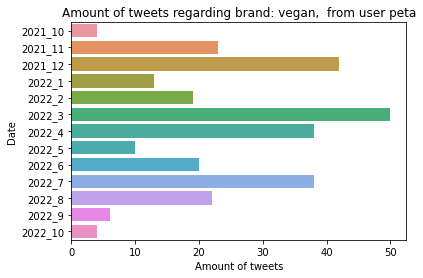

Account with the highest amount of followers tweeting about: keto


+---------------+--------------+-------------------+---------------+---------+
|           name|   screen_name|amount_of_followers|count_of_tweets|   weight|
+---------------+--------------+-------------------+---------------+---------+
|         Forbes|        Forbes|           17422776|              8|139382208|
|       HuffPost|      HuffPost|           11352371|              1| 11352371|
|MUY Interesante|muyinteresante|            8371590|              1|  8371590|
|  El Espectador|  elespectador|            6445503|              1|  6445503|
|      USA TODAY|      USATODAY|            4809532|              1|  4809532|
+---------------+--------------+-------------------+---------------+---------+
only showing top 5 rows

Account with the highest amount of tweets tweeting about: keto


+--------------------+--------------+-------------------+---------------+------+
|                name|   screen_name|amount_of_followers|count_of_tweets|weight|
+--------------------+--------------+-------------------+---------------+------+
|    All Express News|  CrowdVectors|                472|           1070|505040|
|    Health & Fitness|keephealthbest|                622|            451|280522|
|  Healthyweightloss7|   Healthy0007|                 45|            423| 19035|
|Judy Green & Help...|judygreene1998|                216|            421| 90936|
|       けと(bot関係)|       keto_ts|                  6|            339|  2034|
+--------------------+--------------+-------------------+---------------+------+
only showing top 5 rows

Account with the heighest weight: keto


+----------------+--------------+-------------------+---------------+---------+
|            name|   screen_name|amount_of_followers|count_of_tweets|   weight|
+----------------+--------------+-------------------+---------------+---------+
|          Forbes|        Forbes|           17422776|              8|139382208|
|The Kelly O Show| TheKellyOShow|             106048|            321| 34041408|
|Men's Health Mag| MensHealthMag|            4459845|              7| 31218915|
|      KellyOlexa|    KellyOlexa|              67173|            292| 19614516|
|  Raymond Norman|Raymond_Norman|              52898|            284| 15023032|
+----------------+--------------+-------------------+---------------+---------+
only showing top 5 rows

Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: keto


+-----------------+--------------+-------------------+---------------+--------+
|             name|   screen_name|amount_of_followers|count_of_tweets|  weight|
+-----------------+--------------+-------------------+---------------+--------+
| The Kelly O Show| TheKellyOShow|             106048|            321|34041408|
|       KellyOlexa|    KellyOlexa|              67173|            292|19614516|
|   Raymond Norman|Raymond_Norman|              52898|            284|15023032|
|       Amy Berger| TuitNutrition|              54890|             57| 3128730|
|Martina Slajerova|   ketodietapp|              25741|            117| 3011697|
+-----------------+--------------+-------------------+---------------+--------+
only showing top 5 rows



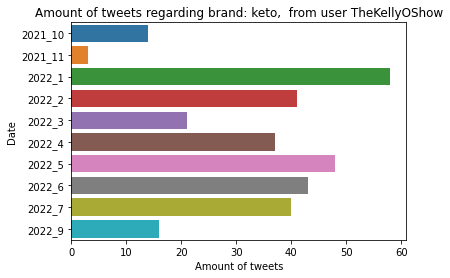

Account with the highest amount of followers tweeting about: ketodiet


+-------------------+--------------+-------------------+---------------+------+
|               name|   screen_name|amount_of_followers|count_of_tweets|weight|
+-------------------+--------------+-------------------+---------------+------+
|        TV9 Marathi|    TV9Marathi|             788323|              1|788323|
|Eat This, Not That!|EatThisNotThat|             594318|              1|594318|
|          NDTV Food|      NDTVFood|             589368|              1|589368|
|   BBC News Marathi|bbcnewsmarathi|             279317|              1|279317|
|           Medscape|      Medscape|             231200|              1|231200|
+-------------------+--------------+-------------------+---------------+------+
only showing top 5 rows

Account with the highest amount of tweets tweeting about: ketodiet


+-------------------+---------------+-------------------+---------------+--------+
|               name|    screen_name|amount_of_followers|count_of_tweets|  weight|
+-------------------+---------------+-------------------+---------------+--------+
|     ketorecipeblog|ketorecipeblog1|                507|            336|  170352|
|   The Kelly O Show|  TheKellyOShow|             106048|            279|29587392|
|         KellyOlexa|     KellyOlexa|              67173|            250|16793250|
|    Keto_diet28days|   Weightketo28|               1271|            202|  256742|
|keto.challenge_diet|     28dayketo4|               1201|            178|  213778|
+-------------------+---------------+-------------------+---------------+--------+
only showing top 5 rows

Account with the heighest weight: ketodiet


+--------------------+-------------+-------------------+---------------+--------+
|                name|  screen_name|amount_of_followers|count_of_tweets|  weight|
+--------------------+-------------+-------------------+---------------+--------+
|    The Kelly O Show|TheKellyOShow|             106048|            279|29587392|
|          KellyOlexa|   KellyOlexa|              67173|            250|16793250|
|Teresa | MomsWhoS...|  MomsWhoSave|             113218|             13| 1471834|
|       Deon Christie| DeonChristie|              34181|             30| 1025430|
| Eat Healthy is Good|  Lowcarbjiji|               8123|            111|  901653|
+--------------------+-------------+-------------------+---------------+--------+
only showing top 5 rows

Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: ketodiet


+-------------------+---------------+-------------------+---------------+--------+
|               name|    screen_name|amount_of_followers|count_of_tweets|  weight|
+-------------------+---------------+-------------------+---------------+--------+
|   The Kelly O Show|  TheKellyOShow|             106048|            279|29587392|
|         KellyOlexa|     KellyOlexa|              67173|            250|16793250|
|Eat Healthy is Good|    Lowcarbjiji|               8123|            111|  901653|
|  Matthew's Friends|matthewsfriends|               4602|             73|  335946|
|    Keto_diet28days|   Weightketo28|               1271|            202|  256742|
+-------------------+---------------+-------------------+---------------+--------+
only showing top 5 rows



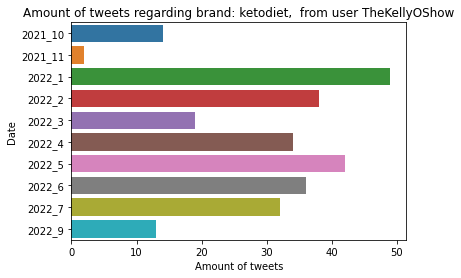

Account with the highest amount of followers tweeting about: ketolifestyle


+----------------+-------------+-------------------+---------------+------+
|            name|  screen_name|amount_of_followers|count_of_tweets|weight|
+----------------+-------------+-------------------+---------------+------+
|The Kelly O Show|TheKellyOShow|             105405|              3|316215|
|      KellyOlexa|   KellyOlexa|              67173|              7|470211|
|Dr. Shriram Nene|   DoctorNene|              42088|              1| 42088|
|     sonyasparks|  sonyasparks|              40418|              1| 40418|
|   Deon Christie| DeonChristie|              34181|              7|239267|
+----------------+-------------+-------------------+---------------+------+
only showing top 5 rows

Account with the highest amount of tweets tweeting about: ketolifestyle


+----------------+---------------+-------------------+---------------+------+
|            name|    screen_name|amount_of_followers|count_of_tweets|weight|
+----------------+---------------+-------------------+---------------+------+
|  ketorecipeblog|ketorecipeblog1|                507|            264|133848|
|       Keto Diet|    Keto101Diet|                781|             91| 71071|
|    #ketoRecipes|ketoRec93974349|               1847|             84|155148|
|ketofitnessfunia|ketofitnessfun2|                172|             65| 11180|
|    CKD Official| theofficialckd|                 67|             54|  3618|
+----------------+---------------+-------------------+---------------+------+
only showing top 5 rows

Account with the heighest weight: ketolifestyle


+----------------+---------------+-------------------+---------------+------+
|            name|    screen_name|amount_of_followers|count_of_tweets|weight|
+----------------+---------------+-------------------+---------------+------+
|Eat Keto With Me|  EatKetoWithMe|              13458|             38|511404|
|      KellyOlexa|     KellyOlexa|              67173|              7|470211|
|The Kelly O Show|  TheKellyOShow|             105405|              3|316215|
|   Deon Christie|   DeonChristie|              34181|              7|239267|
|    #ketoRecipes|ketoRec93974349|               1847|             84|155148|
+----------------+---------------+-------------------+---------------+------+
only showing top 5 rows

Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: ketolifestyle


+----------------+---------------+-------------------+---------------+------+
|            name|    screen_name|amount_of_followers|count_of_tweets|weight|
+----------------+---------------+-------------------+---------------+------+
|    #ketoRecipes|ketoRec93974349|               1847|             84|155148|
|  ketorecipeblog|ketorecipeblog1|                507|            264|133848|
|       Keto Diet|    Keto101Diet|                781|             91| 71071|
|ketofitnessfunia|ketofitnessfun2|                172|             65| 11180|
|    CKD Official| theofficialckd|                 67|             54|  3618|
+----------------+---------------+-------------------+---------------+------+
only showing top 5 rows



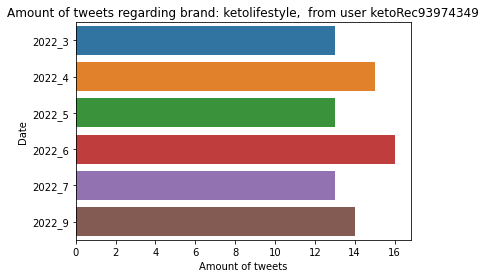

Account with the highest amount of followers tweeting about: veganism


+--------------+-------------+-------------------+---------------+-------+
|          name|  screen_name|amount_of_followers|count_of_tweets| weight|
+--------------+-------------+-------------------+---------------+-------+
|The Daily Show| TheDailyShow|            9620433|              1|9620433|
|     NTV Kenya|     ntvkenya|            3342137|              1|3342137|
|           RAE|   RAEinforma|            1982187|              2|3964374|
|      INDOZONE|indozonemedia|            1765735|              1|1765735|
|  Grazia India|  GraziaIndia|            1585080|              1|1585080|
+--------------+-------------+-------------------+---------------+-------+
only showing top 5 rows

Account with the highest amount of tweets tweeting about: veganism


+-----------------+---------------+-------------------+---------------+-------+
|             name|    screen_name|amount_of_followers|count_of_tweets| weight|
+-----------------+---------------+-------------------+---------------+-------+
|Ranjan Kumar Sahu|  Author_Ranjan|              10709|            751|8042459|
|     Vivian Aaron|   VivianAaron5|                 75|            477|  35775|
| BeYourHealthiest|BeYouHealthiest|                 32|            361|  11552|
|          michael|  MiMuawakening|               2798|            243| 679914|
|   Roshni Sanghvi| roshni_sanghvi|                369|            240|  88560|
+-----------------+---------------+-------------------+---------------+-------+
only showing top 5 rows

Account with the heighest weight: veganism


+-----------------+-------------+-------------------+---------------+-------+
|             name|  screen_name|amount_of_followers|count_of_tweets| weight|
+-----------------+-------------+-------------------+---------------+-------+
|   The Daily Show| TheDailyShow|            9620433|              1|9620433|
|Ranjan Kumar Sahu|Author_Ranjan|              10709|            751|8042459|
|              RAE|   RAEinforma|            1982187|              2|3964374|
|        NTV Kenya|     ntvkenya|            3342137|              1|3342137|
|    Rick London Ⓥ|   ricklondon|              21544|            138|2973072|
+-----------------+-------------+-------------------+---------------+-------+
only showing top 5 rows

Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: veganism


+--------------------+--------------+-------------------+---------------+-------+
|                name|   screen_name|amount_of_followers|count_of_tweets| weight|
+--------------------+--------------+-------------------+---------------+-------+
|   Ranjan Kumar Sahu| Author_Ranjan|              10709|            751|8042459|
|       Rick London Ⓥ|    ricklondon|              21544|            138|2973072|
|          #veganhour|     veganhour|              32002|             84|2688168|
|Prof. Gary Francione|garylfrancione|              15682|             94|1474108|
|    Vegan Recipes 🥦|  vegan_videos|               7613|            137|1042981|
+--------------------+--------------+-------------------+---------------+-------+
only showing top 5 rows



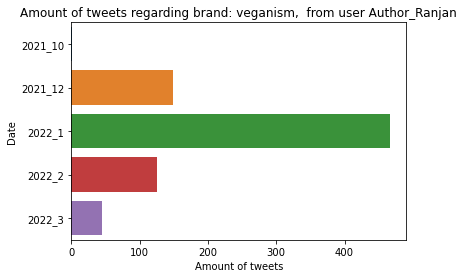

Account with the highest amount of followers tweeting about: vegetarian


+------------------+-----------+-------------------+---------------+--------+
|              name|screen_name|amount_of_followers|count_of_tweets|  weight|
+------------------+-----------+-------------------+---------------+--------+
|The New York Times|    nytimes|           51669771|              1|51669771|
|          detikcom|   detikcom|           18261189|              2|36522378|
|     BBC News (UK)|    BBCNews|           13623855|              1|13623855|
|      The Guardian|   guardian|           10318839|              1|10318839|
|         TIMES NOW|   TimesNow|           10139182|              1|10139182|
+------------------+-----------+-------------------+---------------+--------+
only showing top 5 rows

Account with the highest amount of tweets tweeting about: vegetarian


+--------------------+---------------+-------------------+---------------+-------+
|                name|    screen_name|amount_of_followers|count_of_tweets| weight|
+--------------------+---------------+-------------------+---------------+-------+
|         GUD Capital|     GUDCapital|               2184|            404| 882336|
|           Anonymous|Anonymo96019740|                 19|            393|   7467|
|Organic Dishes | ...|  organicdishes|               7440|            364|2708160|
|          GastroZone|     GastroZone|                276|            325|  89700|
|       Marcus Serrao|   SerraoMarcus|               1440|            296| 426240|
+--------------------+---------------+-------------------+---------------+-------+
only showing top 5 rows

Account with the heighest weight: vegetarian


+------------------+-----------+-------------------+---------------+--------+
|              name|screen_name|amount_of_followers|count_of_tweets|  weight|
+------------------+-----------+-------------------+---------------+--------+
|The New York Times|    nytimes|           51669771|              1|51669771|
|       Food & Wine|foodandwine|            6808901|              6|40853406|
|          detikcom|   detikcom|           18261189|              2|36522378|
|         The Hindu|  the_hindu|            7459497|              4|29837988|
|        Kompas.com|  kompascom|            8489063|              2|16978126|
+------------------+-----------+-------------------+---------------+--------+
only showing top 5 rows

Highest weight (amount_followers*count_of_tweets) accounts with at least 50 tweets tweeting about: vegetarian


+--------------------+---------------+-------------------+---------------+-------+
|                name|    screen_name|amount_of_followers|count_of_tweets| weight|
+--------------------+---------------+-------------------+---------------+-------+
|      Raymond Norman| Raymond_Norman|              52898|            160|8463680|
|         VeganFamily|    veganfamily|              19671|            167|3285057|
|     SeasonalRecipes|InSeasonRecipes|              16232|            189|3067848|
|       Rick London Ⓥ|     ricklondon|              21544|            139|2994616|
|Organic Dishes | ...|  organicdishes|               7440|            364|2708160|
+--------------------+---------------+-------------------+---------------+-------+
only showing top 5 rows



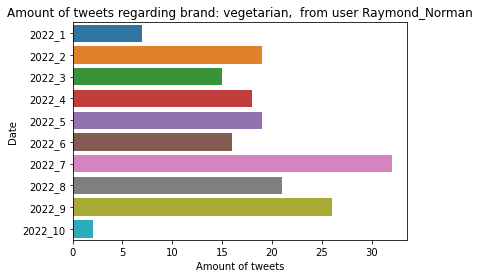

In [80]:
for brand in list_brands:
    info_brands(brand)

### 3.5 The number of likes for a brand post

In [5]:
list_brands = ["healthyfood", 
               "healthylifestyle",
               "vegan",
               "keto",
               "ketodiet",
               "ketolifestyle",
               "veganism",
               "vegetarian"]

In [6]:
# twitter represents likes as hearts 
# the number of likes different topics receive over time 
# use favorites_count 


#plot amount of tweets around a topic over time

df_json_sub = df_json.select(F.col("user.name"),
                                F.col("user.screen_name"),
                                F.col("created_at"), 
                                F.col("full_text"),  
                                F.col("user.followers_count"), 
                                F.col("favorite_count"), 
                                )
#date --> time stamp variable 
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None
date_udf = F.udf(getDate, StringType())
df_json_sub = df_json_sub.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

#extract year, month, day 

df_json_sub = df_json_sub.withColumn('year', year('post_created_at'))
df_json_sub = df_json_sub.withColumn('month', month('post_created_at'))
df_json_sub = df_json_sub.withColumn('day', dayofmonth('post_created_at'))


#drop duplicates  
df_json_sub = df_json_sub.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates().cache()
df_json_sub.printSchema()


root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- post_created_at: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)



       date  freq  likes
0   2021_10  2579   4313
1   2021_11  4140   8015
2   2021_12  1249   1727
3    2022_1  7539  16502
4    2022_2  5375  10786
5    2022_3  2196   3101
6    2022_4  5672  10974
7    2022_5  4039   7048
8    2022_6  4753  12888
9    2022_7  4758  20577
10   2022_8   641   1326
11   2022_9  4206  12663
12  2022_10    71     70


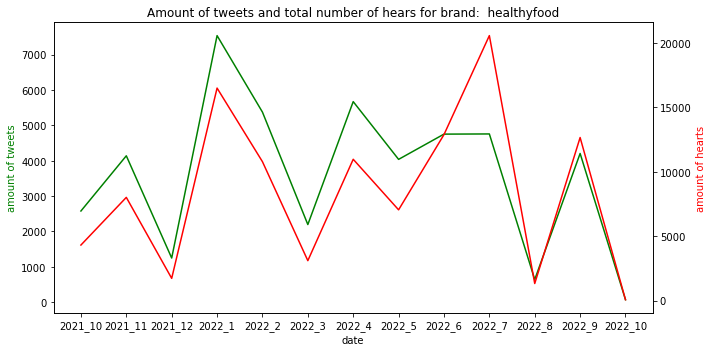

       date   freq  likes
0   2021_10   2104   3154
1   2021_11   4475   7338
2   2021_12    707   1050
3    2022_1  10814  28781
4    2022_2   6124  13847
5    2022_3   2322   5255
6    2022_4  10626  20001
7    2022_5   2154   4020
8    2022_6   3910   6935
9    2022_7   7200  17724
10   2022_8    566    750
11   2022_9   2294   6522
12  2022_10     74    186


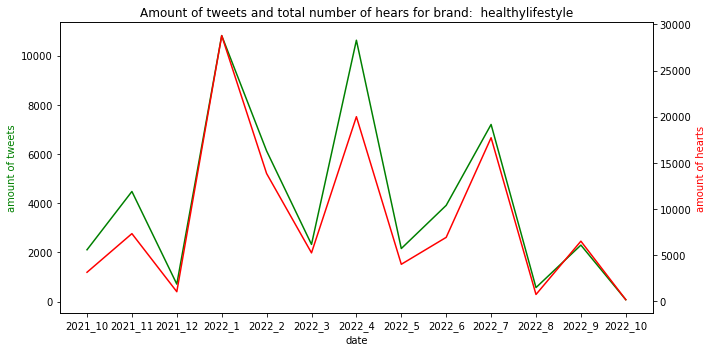

       date   freq   likes
0   2021_10  32685  223897
1   2021_11  37964  245706
2   2021_12  67398  607528
3    2022_1  29012  183482
4    2022_2  38086  294545
5    2022_3  70709  644697
6    2022_4  52164  467624
7    2022_5  32032  268058
8    2022_6  38507  353772
9    2022_7  69980  840386
10   2022_8  67053  507168
11   2022_9  16835  145726
12  2022_10   3166   31178


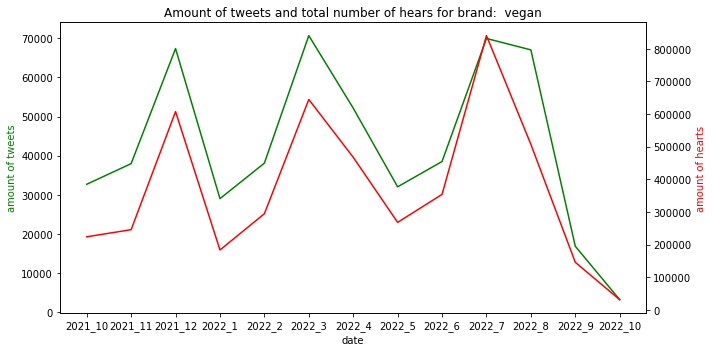

       date   freq  likes
0   2021_10   3495  10369
1   2021_11   8036  42161
2   2021_12   1015   2822
3    2022_1  12100  40529
4    2022_2  10584  41068
5    2022_3   2473  10007
6    2022_4   9811  34953
7    2022_5   9843  31412
8    2022_6  10298  50699
9    2022_7  11810  58878
10   2022_8    305   1274
11   2022_9   9776  45268
12  2022_10     22    107


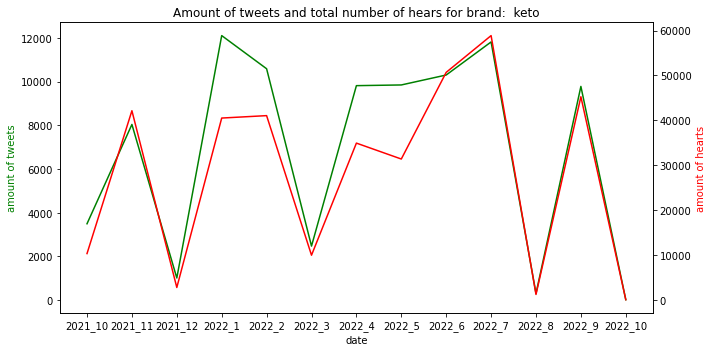

       date  freq  likes
0   2021_10   612   1004
1   2021_11   924   2829
2   2021_12   128    779
3    2022_1  1667   3892
4    2022_2  1124   7555
5    2022_3   471   1317
6    2022_4   854   3317
7    2022_5   951   3945
8    2022_6   850   6269
9    2022_7  1094  12214
10   2022_8    33     14
11   2022_9   573   5277
12  2022_10     3      0


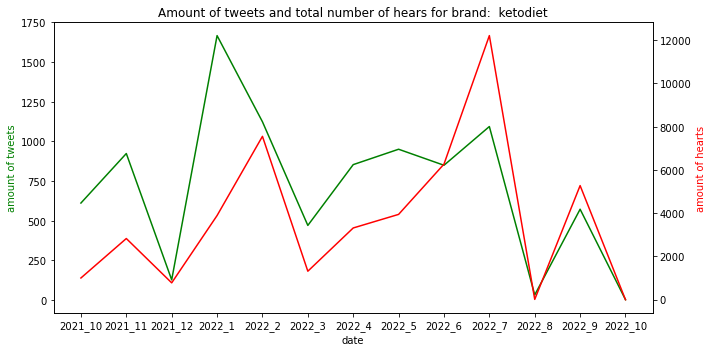

       date  freq  likes
0   2021_10   260    875
1   2021_11   394   1872
2   2021_12    37     91
3    2022_1   399    972
4    2022_2   169    658
5    2022_3    86    401
6    2022_4   131   1536
7    2022_5   130   1033
8    2022_6   138   2448
9    2022_7   216   2869
10   2022_8     3      2
11   2022_9   149   1401


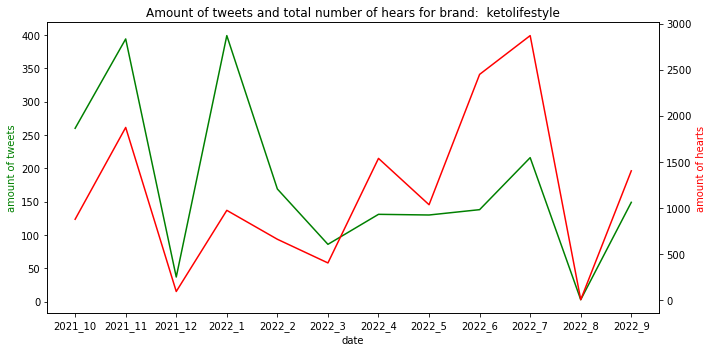

       date  freq  likes
0   2021_10  2311  19960
1   2021_11  3571  27507
2   2021_12  2282  20375
3    2022_1  2113   9399
4    2022_2  5502  48101
5    2022_3  4260  47706
6    2022_4  4334  53205
7    2022_5  1745  15869
8    2022_6  2480  17114
9    2022_7  4880  49765
10   2022_8  3990  34567
11   2022_9   880   9810
12  2022_10   156   1994


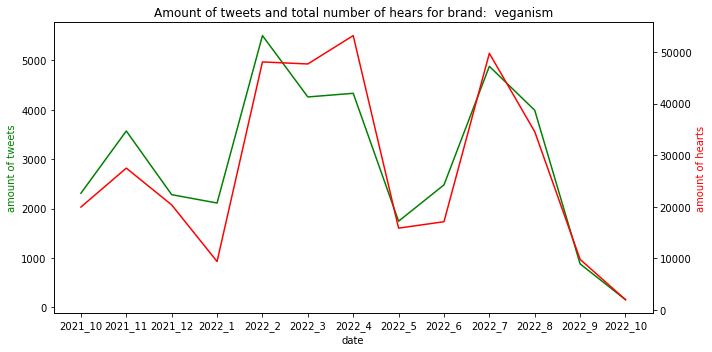

       date   freq  likes
0   2021_10   1347   5569
1   2021_11   2255   7487
2   2021_12  12563  75370
3    2022_1   2172   5892
4    2022_2   5686  24330
5    2022_3  16677  97308
6    2022_4   7267  39526
7    2022_5  14798  85196
8    2022_6   2207   8535
9    2022_7   3728  16943
10   2022_8   4128  21467
11   2022_9   2024   4826
12  2022_10    191    372


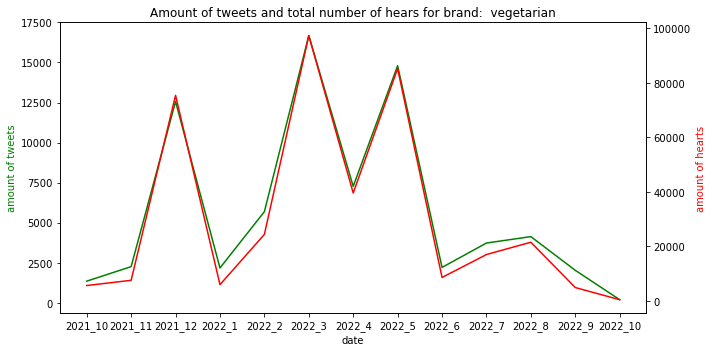

In [7]:
#give brand and graph amount of tweets per month containing brand 
def followers_over_time(brand):
    df_month = df_json_sub.filter(df_json_sub.full_text.contains(brand))
    df_month = df_month.groupBy('year', 'month')\
                        .agg(countDistinct("full_text"), sum("favorite_count"))\
                        .withColumnRenamed("count(full_text)", "freq") \
                        .withColumnRenamed("sum(favorite_count)", "likes") \
                            .sort('year', 'month', ascending = True)
    df_month = df_month.select(concat_ws('_',df_month.year, df_month.month)\
                               .alias('date'), 'freq', 'likes').toPandas()
    print(df_month)
    
    fig, ax = plt.subplots(figsize = (10, 5))
    plt.title('Amount of tweets and total number of hears for brand:  ' + brand)
    ax2 = ax.twinx()
    ax.plot("date","freq", data = df_month, color = 'g')
    ax2.plot("date", "likes", data = df_month, color = 'r')
    ax.set_xlabel('date')
    ax.set_ylabel('amount of tweets', color = 'g')
    ax2.set_ylabel('amount of hearts', color = 'r')
    plt.tight_layout()
    plt.show()

    
for brand in list_brands: 
    followers_over_time(brand) 

### 3.6 The number and impact of influencers for each brand

We define an influencer as an account with the following characteristics:

- a lot of followers => follower_count > 10000
- there is a high engagement rate on their tweets which shows their influence => er > 0.05
- tweet frequency is high enough => freq_weekly > 20

The number of influencers depends on our thresholds. Their impact can be seen as their engagement rate.
More can be seen at question 3.16

### 3.7 The volume of tweets

First we will look at the total number of tweets

In [5]:
# select interesting features 
twitter_sub = df_json.select(F.col("user.name"),
                                F.col("user.screen_name"),
                                F.col("created_at"), 
                                F.col("full_text"),
                                F.col("user.followers_count"),
                                F.col("entities.hashtags"))

In [6]:
# check
twitter_sub.limit(5).toPandas()

,name,screen_name,created_at,full_text,followers_count,hashtags
0,のり/Nori,nori_k_629,Mon Apr 04 10:09:55 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,139,[]
1,alice,myn4meizalize,Mon Apr 04 10:09:54 +0000 2022,RT @mynameisnanon: คิดถึงกันป่าว ถ้าคิดถึงต้อง...,655,[]
2,Karen Reed 🌸,kandk670,Mon Apr 04 10:09:54 +0000 2022,@trudiebakescake Organic coconut oil in a jar ...,711,[]
3,ハル):),patlnwza55,Mon Apr 04 10:09:52 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,236,[]
4,alice,myn4meizalize,Mon Apr 04 10:09:52 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,655,[]


In [7]:
# remove duplicates and retweets
df = twitter_sub.filter(~F.col("full_text").startswith("RT")) \
                               .drop_duplicates() \
                               .cache()
#removing spam accounts 
df = df.drop_duplicates(["full_text", "screen_name"])
                        
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)



In [8]:
# calculate the number of tweets in our dataset 
df.select("full_text").count()

22/12/06 10:49:38 WARN MemoryStore: Not enough space to cache rdd_13_129 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:38 WARN BlockManager: Persisting block rdd_13_129 to disk instead.


22/12/06 10:49:38 WARN MemoryStore: Not enough space to cache rdd_13_135 in memory! (computed 3.4 MiB so far)
22/12/06 10:49:38 WARN BlockManager: Persisting block rdd_13_135 to disk instead.
22/12/06 10:49:38 WARN MemoryStore: Not enough space to cache rdd_13_136 in memory! (computed 3.2 MiB so far)
22/12/06 10:49:38 WARN BlockManager: Persisting block rdd_13_136 to disk instead.
22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_143 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:39 WARN BlockManager: Persisting block rdd_13_143 to disk instead.
22/12/06 10:49:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_149 in memory.
22/12/06 10:49:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_148 in memory.
22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_149 in memory! (computed 384.0 B so far)
22/12/06 10:49:39 WARN BlockManager: Persist

22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_148 in memory! (computed 3.4 MiB so far)
22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_152 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:39 WARN BlockManager: Persisting block rdd_13_152 to disk instead.


22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_156 in memory! (computed 3.4 MiB so far)
22/12/06 10:49:39 WARN BlockManager: Persisting block rdd_13_156 to disk instead.
22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_156 in memory! (computed 3.4 MiB so far)
22/12/06 10:49:39 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_163 in memory.
22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_163 in memory! (computed 384.0 B so far)
22/12/06 10:49:39 WARN BlockManager: Persisting block rdd_13_163 to disk instead.
22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_164 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:39 WARN BlockManager: Persisting block rdd_13_164 to disk instead.
22/12/06 10:49:39 WARN MemoryStore: Not enough space to cache rdd_13_162 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:39 WARN BlockManager: Persisting block rdd_13_162 to d

22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_162 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_163 in memory! (computed 3.4 MiB so far)


22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_167 in memory! (computed 3.4 MiB so far)
22/12/06 10:49:40 WARN BlockManager: Persisting block rdd_13_167 to disk instead.
22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_169 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:40 WARN BlockManager: Persisting block rdd_13_169 to disk instead.
22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_169 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_173 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:40 WARN BlockManager: Persisting block rdd_13_173 to disk instead.
22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_172 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:40 WARN BlockManager: Persisting block rdd_13_172 to disk instead.
22/12/06 10:49:40 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_17

22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_179 in memory! (computed 3.4 MiB so far)
22/12/06 10:49:40 WARN BlockManager: Persisting block rdd_13_179 to disk instead.
22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_183 in memory! (computed 3.4 MiB so far)
22/12/06 10:49:40 WARN BlockManager: Persisting block rdd_13_183 to disk instead.
22/12/06 10:49:40 WARN MemoryStore: Not enough space to cache rdd_13_183 in memory! (computed 3.4 MiB so far)


22/12/06 10:49:41 WARN MemoryStore: Not enough space to cache rdd_13_187 in memory! (computed 3.4 MiB so far)
22/12/06 10:49:41 WARN BlockManager: Persisting block rdd_13_187 to disk instead.
22/12/06 10:49:41 WARN MemoryStore: Not enough space to cache rdd_13_189 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:41 WARN BlockManager: Persisting block rdd_13_189 to disk instead.
22/12/06 10:49:41 WARN MemoryStore: Not enough space to cache rdd_13_189 in memory! (computed 3.3 MiB so far)
22/12/06 10:49:41 WARN MemoryStore: Not enough space to cache rdd_13_187 in memory! (computed 3.4 MiB so far)


1340938

We have a total of 1340938 distinct tweets

Now we will look at the number of distinct users that tweeted about the subject 

In [7]:
# select the number of distinct users from our dataframe 
numberOfUsers = df.select(F.countDistinct("screen_name").alias("NumberOfUsers"))

In [8]:
numberOfUsers.show()

22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_127 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:17 WARN BlockManager: Persisting block rdd_13_127 to disk instead.
22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_127 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_128 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:17 WARN BlockManager: Persisting block rdd_13_128 to disk instead.


22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_135 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:17 WARN BlockManager: Persisting block rdd_13_135 to disk instead.
22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_135 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_140 in memory.
22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_140 in memory! (computed 384.0 B so far)
22/12/06 10:52:17 WARN BlockManager: Persisting block rdd_13_140 to disk instead.
22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_137 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:17 WARN BlockManager: Persisting block rdd_13_137 to disk instead.
22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_137 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:17 WARN MemoryStore: Not enough space to cache rdd_13_

22/12/06 10:52:18 WARN MemoryStore: Not enough space to cache rdd_13_147 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:18 WARN BlockManager: Persisting block rdd_13_147 to disk instead.
22/12/06 10:52:18 WARN MemoryStore: Not enough space to cache rdd_13_147 in memory! (computed 3.3 MiB so far)


22/12/06 10:52:18 WARN MemoryStore: Not enough space to cache rdd_13_155 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:18 WARN BlockManager: Persisting block rdd_13_155 to disk instead.
22/12/06 10:52:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_160 in memory.
22/12/06 10:52:18 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_155 in memory.
22/12/06 10:52:18 WARN MemoryStore: Not enough space to cache rdd_13_155 in memory! (computed 384.0 B so far)
22/12/06 10:52:18 WARN MemoryStore: Not enough space to cache rdd_13_160 in memory! (computed 384.0 B so far)
22/12/06 10:52:18 WARN BlockManager: Persisting block rdd_13_160 to disk instead.
22/12/06 10:52:18 WARN MemoryStore: Not enough space to cache rdd_13_163 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:18 WARN BlockManager: Persisting block rdd_13_163 to disk instead.
22/12/06 10:52:18 WARN MemoryStore: Not enou

22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_172 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_172 to disk instead.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_173 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_173 to disk instead.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_177 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_177 to disk instead.


22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_178 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_178 to disk instead.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_185 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_185 to disk instead.


22/12/06 10:52:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_185 in memory.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_185 in memory! (computed 384.0 B so far)
22/12/06 10:52:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_188 in memory.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_183 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_182 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_182 to disk instead.
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_183 to disk instead.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_182 in memory! (computed 3.3 MiB so far)
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_183 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:1

22/12/06 10:52:19 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_13_196 in memory.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_190 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_190 to disk instead.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_188 in memory! (computed 3.4 MiB so far)
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_196 in memory! (computed 384.0 B so far)
22/12/06 10:52:19 WARN BlockManager: Persisting block rdd_13_196 to disk instead.
22/12/06 10:52:19 WARN MemoryStore: Not enough space to cache rdd_13_190 in memory! (computed 3.4 MiB so far)


+-------------+
|NumberOfUsers|
+-------------+
|       577959|
+-------------+



There are a total of 577959 users that posted a tweet about the subject 

There were a total number of 1340938 tweets so this means that each user posts 2,32 tweets on average

Now we will look at the number of tweets per keyword

In [10]:
def nr_of_tweets(keyword, df):
    df = df.filter(df.full_text.contains(keyword))
    return df.count()

In [11]:
tweets_vegan = nr_of_tweets("vegan", df)

22/12/06 10:54:22 WARN MemoryStore: Not enough space to cache rdd_17_125 in memory! (computed 3.3 MiB so far)
22/12/06 10:54:22 WARN BlockManager: Persisting block rdd_17_125 to disk instead.


22/12/06 10:54:22 WARN MemoryStore: Not enough space to cache rdd_17_128 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:22 WARN BlockManager: Persisting block rdd_17_128 to disk instead.
22/12/06 10:54:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_134 in memory.
22/12/06 10:54:22 WARN MemoryStore: Not enough space to cache rdd_17_128 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:22 WARN MemoryStore: Not enough space to cache rdd_17_134 in memory! (computed 384.0 B so far)
22/12/06 10:54:22 WARN BlockManager: Persisting block rdd_17_134 to disk instead.


22/12/06 10:54:22 WARN MemoryStore: Not enough space to cache rdd_17_132 in memory! (computed 3.3 MiB so far)
22/12/06 10:54:22 WARN BlockManager: Persisting block rdd_17_132 to disk instead.
22/12/06 10:54:22 WARN MemoryStore: Not enough space to cache rdd_17_132 in memory! (computed 3.3 MiB so far)


22/12/06 10:54:22 WARN MemoryStore: Not enough space to cache rdd_17_137 in memory! (computed 3.3 MiB so far)
22/12/06 10:54:22 WARN BlockManager: Persisting block rdd_17_137 to disk instead.
22/12/06 10:54:23 WARN MemoryStore: Not enough space to cache rdd_17_140 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:23 WARN BlockManager: Persisting block rdd_17_140 to disk instead.
22/12/06 10:54:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_147 in memory.
22/12/06 10:54:23 WARN MemoryStore: Not enough space to cache rdd_17_147 in memory! (computed 384.0 B so far)
22/12/06 10:54:23 WARN BlockManager: Persisting block rdd_17_147 to disk instead.


22/12/06 10:54:23 WARN MemoryStore: Not enough space to cache rdd_17_155 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:23 WARN BlockManager: Persisting block rdd_17_155 to disk instead.


22/12/06 10:54:23 WARN MemoryStore: Not enough space to cache rdd_17_157 in memory! (computed 3.3 MiB so far)
22/12/06 10:54:23 WARN BlockManager: Persisting block rdd_17_157 to disk instead.
22/12/06 10:54:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_157 in memory.
22/12/06 10:54:23 WARN MemoryStore: Not enough space to cache rdd_17_157 in memory! (computed 384.0 B so far)


22/12/06 10:54:24 WARN MemoryStore: Not enough space to cache rdd_17_167 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:24 WARN BlockManager: Persisting block rdd_17_167 to disk instead.
22/12/06 10:54:24 WARN MemoryStore: Not enough space to cache rdd_17_167 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:24 WARN MemoryStore: Not enough space to cache rdd_17_168 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:24 WARN BlockManager: Persisting block rdd_17_168 to disk instead.
22/12/06 10:54:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_174 in memory.


22/12/06 10:54:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_177 in memory.
22/12/06 10:54:24 WARN MemoryStore: Not enough space to cache rdd_17_174 in memory! (computed 384.0 B so far)
22/12/06 10:54:24 WARN BlockManager: Persisting block rdd_17_174 to disk instead.
22/12/06 10:54:24 WARN MemoryStore: Not enough space to cache rdd_17_177 in memory! (computed 384.0 B so far)
22/12/06 10:54:24 WARN BlockManager: Persisting block rdd_17_177 to disk instead.


22/12/06 10:54:24 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_185 in memory.
22/12/06 10:54:24 WARN MemoryStore: Not enough space to cache rdd_17_185 in memory! (computed 384.0 B so far)
22/12/06 10:54:24 WARN BlockManager: Persisting block rdd_17_185 to disk instead.
22/12/06 10:54:24 WARN MemoryStore: Not enough space to cache rdd_17_181 in memory! (computed 3.3 MiB so far)
22/12/06 10:54:24 WARN BlockManager: Persisting block rdd_17_181 to disk instead.
22/12/06 10:54:24 WARN MemoryStore: Not enough space to cache rdd_17_181 in memory! (computed 3.3 MiB so far)


22/12/06 10:54:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_192 in memory.
22/12/06 10:54:25 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_195 in memory.
22/12/06 10:54:25 WARN MemoryStore: Not enough space to cache rdd_17_191 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:25 WARN BlockManager: Persisting block rdd_17_191 to disk instead.
22/12/06 10:54:25 WARN MemoryStore: Not enough space to cache rdd_17_192 in memory! (computed 384.0 B so far)
22/12/06 10:54:25 WARN BlockManager: Persisting block rdd_17_192 to disk instead.
22/12/06 10:54:25 WARN MemoryStore: Not enough space to cache rdd_17_189 in memory! (computed 3.3 MiB so far)
22/12/06 10:54:25 WARN BlockManager: Persisting block rdd_17_189 to disk instead.
22/12/06 10:54:25 WARN MemoryStore: Not enough space to cache rdd_17_191 in memory! (computed 3.4 MiB so far)
22/12/06 10:54:25 WARN MemoryStore: Not enou

22/12/06 10:54:25 WARN MemoryStore: Not enough space to cache rdd_17_197 in memory! (computed 3.3 MiB so far)
22/12/06 10:54:25 WARN BlockManager: Persisting block rdd_17_197 to disk instead.
22/12/06 10:54:25 WARN MemoryStore: Not enough space to cache rdd_17_197 in memory! (computed 3.3 MiB so far)


In [12]:
print(tweets_vegan)

551736


Next we will look at the number of users that tweeted a certain keyword

In [13]:
def nr_of_users(keyword, df):
    df = df.filter(df.full_text.contains(keyword))
    # select the number of distinct users from our dataframe 
    numberOfUsers = df.select(F.countDistinct("screen_name").alias("NumberOfUsers"))
    numberOfUsers.show()

In [14]:
nr_of_users("vegan", df)

22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_46 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_49 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_48 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_51 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_52 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_56 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_58 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_57 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:11 WARN MemoryStore: Not enough space to cache rdd_17_55 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:11 W

22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_63 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_66 in memory.
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_66 in memory! (computed 384.0 B so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_65 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_68 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_69 in memory.
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_69 in memory! (computed 384.0 B so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_70 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_71 in mem

22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_74 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_76 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_77 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_75 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_79 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_78 in memory! (computed 3.4 MiB so far)


22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_83 in memory! (computed 3.4 MiB so far)


22/12/06 10:57:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_91 in memory.
22/12/06 10:57:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_84 in memory.
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_89 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_87 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_85 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_91 in memory! (computed 384.0 B so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_84 in memory! (computed 384.0 B so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_86 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:12 WARN MemoryStore: Not enough space to cache rdd_17_90 in mem

22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_98 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_97 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_99 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_100 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_102 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_105 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_103 in memory! (computed 3.3 MiB so far)


22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_108 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_106 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_112 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_116 in memory.
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_114 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_115 in memory! (computed 3.5 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_116 in memory! (computed 384.0 B so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_118 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_119 in memory! (computed 3

22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_123 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_125 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_127 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_128 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_130 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:13 WARN MemoryStore: Not enough space to cache rdd_17_132 in memory! (computed 3.3 MiB so far)


22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_135 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_138 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_139 in memory.
22/12/06 10:57:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_17_140 in memory.
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_140 in memory! (computed 384.0 B so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_141 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_139 in memory! (computed 384.0 B so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_142 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_1

22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_144 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_147 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_145 in memory! (computed 3.4 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_149 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_150 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_152 in memory! (computed 3.3 MiB so far)


22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_157 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_169 in memory! (computed 3.3 MiB so far)


22/12/06 10:57:14 WARN MemoryStore: Not enough space to cache rdd_17_175 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:15 WARN MemoryStore: Not enough space to cache rdd_17_184 in memory! (computed 3.3 MiB so far)
22/12/06 10:57:15 WARN MemoryStore: Not enough space to cache rdd_17_185 in memory! (computed 3.3 MiB so far)


22/12/06 10:57:15 WARN MemoryStore: Not enough space to cache rdd_17_197 in memory! (computed 3.3 MiB so far)
+-------------+
|NumberOfUsers|
+-------------+
|       253142|
+-------------+



### 3.8 The timing of tweets

We will look at the timing of a tweet per day, so we will look at what owers users post the most tweets 

In [15]:
# select interesting features 
df = df_json.select(F.col("user.name"),
                                F.col("user.screen_name"),
                                F.col("created_at"), 
                                F.col("full_text"),
                                F.col("user.followers_count"),
                                F.col("entities.hashtags"))

In [16]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [17]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- post_created_at: timestamp (nullable = true)



In [18]:
freq_hour = df.withColumn("hour", hour(df["post_created_at"]))
freq_hour = freq_hour.groupBy('hour').agg(countDistinct("full_text"))\
            .withColumnRenamed("count(full_text)", "freq") \
            .sort('hour', ascending = True).toPandas()
freq_hour.head(24)

22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:47 WARN RowBasedKeyValueBatch: Calling spill() on

22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 10:59:48 WARN RowBasedKeyValueBatch: Calling spill() on

,hour,freq
0,0,71898
1,1,71058
2,2,66172
3,3,63597
4,4,61519
5,5,63714
6,6,65960
7,7,72743
8,8,76546
9,9,79436


In [19]:
fig = px.line(freq_hour, x = 'hour', y= 'freq')

# Add figure title
fig.update_layout(
title_text="Tweet Activity Hourly",
title_x = 0.5
    )

# add axes
fig.update_xaxes(title_text="<b>Hour</b>")
fig.update_yaxes(title_text="<b>Amount of tweets</b>")

fig.show()

Now we will look at hourly tweet activity per keyword

In [20]:
def tweet_activity_hourly(keyword, df):
    df = df.filter(df.full_text.contains(keyword))
    freq_hour = df.withColumn("hour", hour(df["post_created_at"]))
    freq_hour = freq_hour.groupBy('hour').agg(countDistinct("full_text"))\
                .withColumnRenamed("count(full_text)", "freq") \
                .sort('hour', ascending = True).toPandas()
    fig = px.line(freq_hour, x = 'hour', y= 'freq')

    # Add figure title
    fig.update_layout(
    title_text="Tweet Activity Hourly",
    title_x = 0.5
    )

    # add axes
    fig.update_xaxes(title_text="<b>Hour</b>")
    fig.update_yaxes(title_text="<b>Amount of tweets</b>")

    fig.show()
    return freq_hour

In [21]:
hourly_tweets_vegan = tweet_activity_hourly("vegan", df)

In [22]:
hourly_tweets_vegan.head(24)

,hour,freq
0,0,28161
1,1,26879
2,2,24137
3,3,21682
4,4,20236
5,5,20676
6,6,20807
7,7,24536
8,8,26307
9,9,28189


### 3.9 The number of followers of users

Because a user can post more than one tweets about the topic, some users will appear more than once in our dataset. The user can have a different number of followers, becuase the number of followers may have been increased or decreased between the time of the tweets. We decide to take the max of the number of followers for each users.  


In [23]:
# we select the max number of followers for each users 
numberOfFollowers = df.select("name", "followers_count") \
                        .groupBy("name") \
                        .max("followers_count") \
                        .withColumnRenamed("max(followers_count)", "MaxFollowersCount") \
                        .withColumn("MaxFollowersCount", F.round("MaxFollowersCount", 2)) 

In [24]:
# we sort in a decending way
numberOfFollowers = numberOfFollowers.sort("MaxFollowersCount", ascending=False)

In [25]:
# converting to pandas
numberofFollowersPd = numberOfFollowers.toPandas()

In [26]:
# look at the 20 accounts with the largest number of followers
numberofFollowersPd.head(20)

,name,MaxFollowersCount
0,Lady Gaga,84876971
1,CNN,58738132
2,The New York Times,53833653
3,BBC News (World),37368190
4,The Economist,26981263
5,Kourtney Kardashian,26324023
6,Reuters,25387151
7,A.R.Rahman,24192397
8,Nicki Minaj,23311089
9,Fox News,22083552


We can see that the accounts with the largest number of followers are famous people or news sites. Which shows us that it's an item that's actual at the moment

In [27]:
# now we will look how mucht users have 0 followers
zeroFollowers = numberofFollowersPd[numberofFollowersPd['MaxFollowersCount'] == 0]
zeroFollowers.head()

,name,MaxFollowersCount
1163917,Rashid Memon,0
1163918,moya,0
1163919,Donatella Piergiovanni,0
1163920,❁*,0
1163921,春日部宏,0


In [28]:
len(zeroFollowers)

18147

In [29]:
len(zeroFollowers)/len(numberofFollowersPd)

0.01535196063834107

Only 2% of the users have zero followers

In [30]:
# now we will look how mucht users have 0 followers
lessThan1000Followers = numberofFollowersPd[numberofFollowersPd['MaxFollowersCount'] < 1000]
len(lessThan1000Followers)

872004

In [31]:
len(lessThan1000Followers)/len(numberofFollowersPd)

0.7376960976732224

Most users (73,77 %) have less than 1000 followers

In [32]:
# look how much followers our users have on average 
meanFollowers = numberofFollowersPd['MaxFollowersCount'].mean()
meanFollowers

4618.601343074487

Now we will look at the people with the highest number of followers for each keyword 

In [33]:
def nr_of_followers(keyword, df):
    df = df.filter(df.full_text.contains(keyword))
    # we select the max number of followers for each users 
    numberOfFollowers = df.select("name", "followers_count") \
                                        .groupBy("name") \
                                        .max("followers_count") \
                                        .withColumnRenamed("max(followers_count)", "MaxFollowersCount") \
                                        .withColumn("MaxFollowersCount", F.round("MaxFollowersCount", 2))
    
                                        
    # we sort in a decending way
    numberOfFollowers = numberOfFollowers.sort("MaxFollowersCount", ascending=False)
    numberOfFollowers.show()

In [34]:
nr_of_followers("vegan", df)

+--------------------+-----------------+
|                name|MaxFollowersCount|
+--------------------+-----------------+
|           Lady Gaga|         84876971|
|  The New York Times|         53818201|
|       The Economist|         26686134|
|             Reuters|         24739056|
|         Nicki Minaj|         23311089|
|The Wall Street J...|         19901847|
|            detikcom|         18694195|
|      Vogue Magazine|         14688011|
|                CGTN|         13445429|
|       BBC News (UK)|         12979119|
|                 WWE|         11769892|
|    Riteish Deshmukh|         11299240|
|       Russell Brand|         11135448|
|                  +a|         10824177|
|        The Guardian|         10564395|
|           BBC Sport|         10306522|
|          TechCrunch|         10275596|
|               WIRED|         10258749|
|      The Daily Show|          9620433|
|    Noticias Caracol|          9489274|
+--------------------+-----------------+
only showing top

In [35]:
nr_of_followers("healthylifestyle", df)

+--------------------+-----------------+
|                name|MaxFollowersCount|
+--------------------+-----------------+
|                NDTV|         16216077|
|              AajTak|         15854838|
|  The Times Of India|         14483527|
|SHILPA SHETTY KUNDRA|          6459016|
|  The Indian Express|          4133281|
|     Sebastian Rulli|          2918439|
|                 DNA|          2282085|
|            DawnNews|          2189518|
|            India TV|          2064560|
|         News7 Tamil|          1915254|
|       Susan Bennett|          1840748|
|        Ranveer Brar|          1743177|
|        Grazia India|          1583486|
|           Gulf News|          1288490|
|            ABP माझा|          1221739|
|         भारत समाचार|          1033735|
|       National Post|           967473|
|         TV9 Marathi|           903591|
|       Khaleej Times|           846718|
|        Tv9 Gujarati|           801750|
+--------------------+-----------------+
only showing top

### 3.10 The number of likes for a tweet

In [36]:
# select interesting features
df = df_json.select(F.col('user.name'),
                                F.col('user.screen_name'),
                                F.col('user.followers_count'),
                                F.col('user.following'),
                                F.col('user.statuses_count'),
                                F.col('user.listed_count'),
                                F.col('created_at'),
                                F.col('full_text'),
                                F.col('entities.hashtags'),
                                F.col('favorite_count'),
                                F.col('retweet_count'),
                                F.col('user.friends_count'))

In [37]:
# check distribution of likes
df = df.groupBy("favorite_count").count().sort("count", ascending=False)

In [38]:
# plot likes
fig = px.histogram(data_frame= df.select("favorite_count").toPandas(), nbins = 100, log_y=True)
fig.show()

In [39]:
# how many tweets did receive at least 1 like
df.filter(F.col("favorite_count") != 0).count()

1720

### 3.11 The level of engagement for each tweet

In [5]:
df = df_json.select(F.col("user.name"),
                    F.col("user.screen_name"),
                    F.col("created_at"), 
                    F.col("full_text"),
                    F.col("user.followers_count"),
                    F.col("retweet_count"),
                    F.col("favorite_count"),
                    F.col("entities.hashtags"))

In [6]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [7]:
#drop duplicates and retweets 
df = df.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates().cache()
#sorting such when dropping later we only keep the most recent post 
df = df.sort("post_created_at", ascending=False)
#removing spam accounts 
df = df.drop_duplicates(["full_text", "screen_name"])
                        
df.printSchema()
#df.count() #1340938 

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- post_created_at: timestamp (nullable = true)



In [8]:
def eng_rate(keyword, df):
    df = df.filter(df.full_text.contains(keyword))

    eng_rate = df.withColumn('eng_rate', ((df['favorite_count'] + df['retweet_count'])/df['followers_count']))

    eng_rate = eng_rate.withColumn('year', year(df["post_created_at"]))
    eng_rate = eng_rate.withColumn('week', weekofyear('post_created_at'))

    return eng_rate.select("full_text", "eng_rate").show()

In [9]:
eng_rate("vegan", df)

22/12/06 11:09:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_124 in memory.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_119 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_119 to disk instead.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_124 in memory! (computed 384.0 B so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_124 to disk instead.


22/12/06 11:09:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_127 in memory.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_125 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_125 to disk instead.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_123 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_123 to disk instead.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_123 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_125 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_127 in memory! (computed 384.0 B so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_127 to disk instead.
22/12/06 11:09:50 WARN MemoryStore: Failed to reserve initial memory 

22/12/06 11:09:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_135 in memory.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_127 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_131 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_131 to disk instead.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_131 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_135 in memory! (computed 384.0 B so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_135 to disk instead.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 384.0 B so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_136 to disk instead.


22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_138 in memory! (computed 3.3 MiB so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_138 to disk instead.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_137 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:50 WARN BlockManager: Persisting block rdd_16_137 to disk instead.
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:50 WARN MemoryStore: Not enough space to cache rdd_16_138 in memory! (computed 3.3 MiB so far)
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_140 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_140 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_139 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB f

22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_147 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_147 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_152 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_152 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_151 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_151 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_152 in memory.
22/12/06 11:09:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_151 in memory.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_152 in memory! (computed 384.0 B so far)
22/12/06 11:09:51 WARN MemoryStore: Not enou

22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_160 in memory! (computed 384.0 B so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_160 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_160 in memory.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_160 in memory! (computed 384.0 B so far)
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_162 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_162 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_162 in memory! (computed 3.5 MiB so far)


22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_168 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_168 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_165 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_165 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_165 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_167 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_167 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_171 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_171 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_167 in memory! (computed 3.4 MiB so far)
22/12/06 11:

22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_172 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:51 WARN BlockManager: Persisting block rdd_16_172 to disk instead.
22/12/06 11:09:51 WARN MemoryStore: Not enough space to cache rdd_16_173 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_177 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:52 WARN BlockManager: Persisting block rdd_16_177 to disk instead.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_176 in memory! (computed 3.3 MiB so far)
22/12/06 11:09:52 WARN BlockManager: Persisting block rdd_16_176 to disk instead.
22/12/06 11:09:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_176 in memory.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_177 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_

22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_183 in memory! (computed 384.0 B so far)
22/12/06 11:09:52 WARN BlockManager: Persisting block rdd_16_183 to disk instead.
22/12/06 11:09:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_188 in memory.
22/12/06 11:09:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_189 in memory.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_186 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:52 WARN BlockManager: Persisting block rdd_16_186 to disk instead.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_188 in memory! (computed 384.0 B so far)
22/12/06 11:09:52 WARN BlockManager: Persisting block rdd_16_188 to disk instead.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_189 in memory! (computed 384.0 B so far)
22/12/06 11:09:52 WARN BlockManager: Persist

22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_193 in memory! (computed 384.0 B so far)
22/12/06 11:09:52 WARN BlockManager: Persisting block rdd_16_193 to disk instead.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_189 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_188 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_193 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_199 in memory.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_194 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:52 WARN BlockManager: Persisting block rdd_16_194 to disk instead.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_199 in memory! (computed 384.0 B so far)
22/12/06 11:09:52 WARN BlockManager: Pers

22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_4 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_1 in memory.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_6 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_0 in memory.
22/12/06 11:09:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_5 in memory.
22/12/06 11:09:52 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_7 in memory.
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_2 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:52 WARN MemoryStore: Not enough space to cache rdd_16_1 in memory! (computed 384.0 B so far)
22/12/06 11:09:52 WARN MemoryStore: 

22/12/06 11:09:53 WARN MemoryStore: Not enough space to cache rdd_16_30 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_33 in memory.
22/12/06 11:09:53 WARN MemoryStore: Not enough space to cache rdd_16_33 in memory! (computed 384.0 B so far)
22/12/06 11:09:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_35 in memory.
22/12/06 11:09:53 WARN MemoryStore: Not enough space to cache rdd_16_35 in memory! (computed 384.0 B so far)
22/12/06 11:09:53 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_36 in memory.
22/12/06 11:09:53 WARN MemoryStore: Not enough space to cache rdd_16_36 in memory! (computed 384.0 B so far)
22/12/06 11:09:53 WARN MemoryStore: Not enough space to cache rdd_16_34 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:53 WARN MemoryStore: Failed to reserve

22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_125 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_123 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_127 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_131 in memory! (computed 3.4 MiB so far)


22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_138 in memory! (computed 3.3 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_139 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_140 in memory! (computed 3.5 MiB so far)


22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_151 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_152 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_162 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_160 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_167 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:55 WARN MemoryStore: Not enough space to cache rdd_16_165 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_169 in memory! (computed 3.5 MiB so far)


22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_173 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_176 in memory! (computed 3.3 MiB so far)
22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_177 in memory! (computed 3.5 MiB so far)
22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_179 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_186 in memory! (computed 3.4 MiB so far)


22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_189 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_188 in memory! (computed 3.4 MiB so far)
22/12/06 11:09:56 WARN MemoryStore: Not enough space to cache rdd_16_193 in memory! (computed 3.5 MiB so far)


22/12/06 11:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:09:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------------------------------+--------------------+
|                            full_text|            eng_rate|
+-------------------------------------+--------------------+
|                 This afternoon, l...|0.001179245283018...|
|                 Sweet Potato &amp...|0.003097040605643...|
|                 Creamy mushroom b...|0.027937551355792935|
|                 @Polypieter veggi...|                 0.0|
|                 #ICYMI from Folio...|                 0.0|
|                 We made a #vegan ...|5.963313694153567E-5|
|                 Flaunt your flawl...|                 0.0|
|味噌が無くなって買わないとと思い最...|0.004761904761904762|
|                 @veganfuture What...|                 0.0|
|                 The question is d...|2.448280083241523E-4|
|                 Vegans &amp; viol...|1.958863858961802E-4|
|                 [ WERBUNG ] \n+++...|0.043859649122807015|
|                 Erwähne ich, dass...| 0.03837118245888802|
|                 Now show this to ...| 0

### 3.12 The level of social media activity for user

Public metrics can potentially be used to determine a Twitter user’s reach or influence, quantify the user’s range of interests, and the user’s level of engagement on Twitter.
- followers_count: How many followers has a user?
- following: How many accounts does a user follow?   
- friends_count: How many friends has a user
- statuses_count: How many statuses has a user posted? (includedes tweet, retweet and reply)
- listed_count: Twitter Lists allow you to customize, organize and prioritize the Tweets you see in your timeline.

In [6]:
# select interesting features
df = df_json.select(F.col('user.name'),
                                F.col('user.screen_name'),
                                F.col('user.followers_count'),
                                F.col('user.following'),
                                F.col('user.statuses_count'),
                                F.col('user.listed_count'),
                                F.col('created_at'),
                                F.col('full_text'),
                                F.col('entities.hashtags'),
                                F.col('favorite_count'),
                                F.col('retweet_count'),
                                F.col('user.friends_count'))

In [7]:
# check distribution of followers_count
df.groupBy("followers_count").count().sort("count", ascending=False).show()

+---------------+-----+
|followers_count|count|
+---------------+-----+
|              0|43576|
|              1|33378|
|              2|26629|
|              3|23808|
|              4|21296|
|              5|19307|
|              6|18935|
|              7|16371|
|              8|15208|
|              9|13711|
|             10|13361|
|             11|12886|
|             14|12176|
|             13|12101|
|             12|11969|
|             15|11240|
|             16|11106|
|             19|10277|
|             18|10260|
|             24|10114|
+---------------+-----+
only showing top 20 rows



In [8]:
# check distribution of following
df.groupBy("following").count().sort("count", ascending=False).show()

+---------+-------+
|following|  count|
+---------+-------+
|    false|3428543|
|     null|     15|
|     true|      1|
+---------+-------+



In [ ]:
# check distribution of friends_count
df.groupBy("friends_count").count().sort("count", ascending=False).show()

+-------------+-----+
|friends_count|count|
+-------------+-----+
|            0|84138|
|            1|37353|
|            2|18174|
|            3|16816|
|         5001|12013|
|            5|11143|
|            4|10953|
|            8|10571|
|            6| 9316|
|           10| 9309|
|            7| 8613|
|           11| 8431|
|           13| 7977|
|           21| 7862|
|            9| 7786|
|           12| 7745|
|           42| 7714|
|           14| 7531|
|           15| 7282|
|           28| 7211|
+-------------+-----+
only showing top 20 rows



In [17]:
# check distribution of statuses_count
df.groupBy("statuses_count").count().sort("count", ascending=False).show()

+--------------+-----+
|statuses_count|count|
+--------------+-----+
|             3| 2691|
|             2| 2650|
|             4| 2636|
|             6| 2553|
|             1| 2521|
|             5| 2483|
|             9| 2462|
|             8| 2445|
|         14645| 2436|
|             7| 2364|
|            10| 2356|
|            11| 2334|
|            14| 2123|
|            12| 2067|
|            13| 2055|
|            15| 2024|
|            16| 1978|
|            18| 1974|
|            20| 1936|
|            17| 1903|
+--------------+-----+
only showing top 20 rows



In [19]:
# check distribution of listed_count
df.groupBy("listed_count").count().sort("count", ascending=False).show()

+------------+-------+
|listed_count|  count|
+------------+-------+
|           0|1207283|
|           1| 373869|
|           2| 221659|
|           3| 156626|
|           4| 124425|
|           5|  90214|
|           6|  73122|
|           7|  65677|
|           8|  57948|
|           9|  54240|
|          10|  48463|
|          16|  40349|
|          11|  36513|
|          12|  31895|
|          13|  29489|
|          17|  28832|
|          15|  25620|
|          14|  24779|
|          18|  19257|
|          19|  17633|
+------------+-------+
only showing top 20 rows



### 3.13 The evolution of tweet activity

In [7]:
df = df_json.select(F.col("user.name"),
                    F.col("user.screen_name"),
                    F.col("created_at"), 
                    F.col("full_text"),
                    F.col("user.followers_count"),
                    F.col("retweet_count"),
                    F.col("favorite_count"),
                    F.col("entities.hashtags"))

In [8]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [9]:
#drop duplicates and retweets 
df = df.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates().cache()
#sorting such when dropping later we only keep the most recent post 
df = df.sort("post_created_at", ascending=False)
#removing spam accounts 
df = df.drop_duplicates(["full_text", "screen_name"])
                        
df.printSchema()
#df.count() #1340938 

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- post_created_at: timestamp (nullable = true)



Look at the frequency of tweets per month.

In [10]:
def tweet_activity_monthly(keyword, df):
    
    df = df.filter(df.full_text.contains(keyword))

    # freq_month
    freq_month = df.withColumn("year", year(df["post_created_at"]))
    freq_month = freq_month.withColumn("month", month(df["post_created_at"]))

    freq_month = freq_month.groupBy('year', 'month').agg(countDistinct("full_text"))\
                    .withColumnRenamed("count(full_text)", "freq") \
                        .sort('year', 'month', ascending = True)
    freq_month = freq_month.select(concat_ws('_',freq_month.year, freq_month.month)\
                            .alias('date'), 'freq').toPandas()

    fig = px.bar(freq_month, x='date', y='freq')

    # Add figure title
    fig.update_layout(
        title_text="Tweet Activity Monthly " + keyword,
        title_x = 0.5
    )

    # add axes
    fig.update_xaxes(title_text="<b>Month</b>")
    fig.update_yaxes(title_text="<b>Amount of tweets</b>")

    fig.show()

In [11]:
tweet_activity_monthly("vegan", df)

22/12/06 11:22:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_129 in memory.
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_123 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_124 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_123 to disk instead.
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_129 in memory! (computed 384.0 B so far)
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_129 to disk instead.
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_124 to disk instead.


22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_127 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_127 to disk instead.
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_127 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_129 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_131 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_131 to disk instead.
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_132 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_132 to disk instead.
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_132 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_133 in memory! (computed 

22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_134 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_134 to disk instead.
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_136 to disk instead.
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_137 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:03 WARN BlockManager: Persisting block rdd_16_137 to disk instead.
22/12/06 11:22:03 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_146 in memory.
22/12/06 11:22:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_145 in memory.


22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_145 in memory! (computed 384.0 B so far)
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_146 in memory! (computed 384.0 B so far)
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_145 to disk instead.
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_146 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_146 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_148 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_148 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_156 in memory.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_148 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:04 WARN MemoryStore: Failed to reserve initial memory 

22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_158 in memory! (computed 384.0 B so far)
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_158 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_155 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_155 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_156 in memory! (computed 384.0 B so far)
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_156 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_155 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_153 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_153 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_157 in memory! (computed 3.4 MiB so far)
22/12/06 11:

22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_162 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_158 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_162 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_164 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_159 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_164 to disk instead.
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_159 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_160 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:04 WARN BlockManager: Persisting block rdd_16_160 to disk instead.
22/12/06 11:22:04 WARN MemoryStore: Not enough space to cache rdd_16_164 in memory! (computed 3.4 MiB so far)
22/12/06 11:

22/12/06 11:22:07 WARN MemoryStore: Not enough space to cache rdd_16_46 in memory! (computed 3.6 MiB so far)
22/12/06 11:22:07 WARN MemoryStore: Not enough space to cache rdd_16_48 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_47 in memory.
22/12/06 11:22:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_50 in memory.
22/12/06 11:22:07 WARN MemoryStore: Not enough space to cache rdd_16_50 in memory! (computed 384.0 B so far)
22/12/06 11:22:07 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_49 in memory.
22/12/06 11:22:07 WARN MemoryStore: Not enough space to cache rdd_16_49 in memory! (computed 384.0 B so far)
22/12/06 11:22:07 WARN MemoryStore: Not enough space to cache rdd_16_47 in memory! (computed 384.0 B so far)
22/12/06 11:22:08 WARN MemoryStore: Not enough space 

22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_127 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_132 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_131 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_129 in memory! (computed 3.4 MiB so far)


22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_146 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_148 in memory! (computed 3.5 MiB so far)


22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_155 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:10 WARN MemoryStore: Not enough space to cache rdd_16_156 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_158 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_160 in memory.
22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_160 in memory! (computed 384.0 B so far)
22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_162 in memory! (computed 3.5 MiB so far)


22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_164 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_169 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_170 in memory! (computed 3.4 MiB so far)


22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_177 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_176 in memory! (computed 3.3 MiB so far)


22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_186 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_190 in memory! (computed 3.4 MiB so far)


22/12/06 11:22:11 WARN MemoryStore: Not enough space to cache rdd_16_192 in memory! (computed 3.4 MiB so far)


22/12/06 11:22:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Look at the frequency of tweets per week.

In [12]:
def tweet_activity_weekly(keyword, df):
    df = df.filter(df.full_text.contains(keyword))

    freq_week = df.withColumn("year", year(df["post_created_at"]))
    freq_week = freq_week.withColumn('week', weekofyear('post_created_at'))

    freq_week = freq_week.groupBy('year', 'week').agg(countDistinct("full_text"))\
                    .withColumnRenamed("count(full_text)", "freq") \
                        .sort('year', 'week', ascending = True)
    freq_week = freq_week.select(concat_ws('_',freq_week.year, freq_week.week)\
                            .alias('date'), 'freq').toPandas()

    fig = px.line(freq_week, x='date', y='freq')

    # Add figure title
    fig.update_layout(
        title_text="Tweet Activity Weekly",
        title_x = 0.5
    )

    # add axes
    fig.update_xaxes(title_text="<b>Week</b>")
    fig.update_yaxes(title_text="<b>Amount of tweets</b>")

    fig.show()


In [13]:
tweet_activity_weekly("vegan", df)

22/12/06 11:22:43 WARN MemoryStore: Not enough space to cache rdd_16_57 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:43 WARN MemoryStore: Not enough space to cache rdd_16_55 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:43 WARN MemoryStore: Not enough space to cache rdd_16_59 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:43 WARN MemoryStore: Not enough space to cache rdd_16_61 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:43 WARN MemoryStore: Not enough space to cache rdd_16_60 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:43 WARN MemoryStore: Not enough space to cache rdd_16_62 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_68 in memory.
22/12/06 11:22:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_69 in memory.
22/12/06 11:22:43 WARN MemoryStore: Not enough space to cache rdd_16_64 in mem

22/12/06 11:22:44 WARN MemoryStore: Not enough space to cache rdd_16_55 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:44 WARN MemoryStore: Not enough space to cache rdd_16_57 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:44 WARN MemoryStore: Not enough space to cache rdd_16_59 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:44 WARN MemoryStore: Not enough space to cache rdd_16_60 in memory! (computed 3.4 MiB so far)


22/12/06 11:22:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_62 in memory.
22/12/06 11:22:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_63 in memory.
22/12/06 11:22:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_61 in memory.
22/12/06 11:22:44 WARN MemoryStore: Not enough space to cache rdd_16_62 in memory! (computed 384.0 B so far)
22/12/06 11:22:44 WARN MemoryStore: Not enough space to cache rdd_16_63 in memory! (computed 384.0 B so far)
22/12/06 11:22:44 WARN MemoryStore: Not enough space to cache rdd_16_61 in memory! (computed 384.0 B so far)
22/12/06 11:22:44 WARN MemoryStore: Not enough space to cache rdd_16_64 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_66 in memory.
22/12/06 11:22:44 WARN Memor

22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_81 in memory.
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_82 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_83 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_84 in memory.
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_81 in memory! (computed 384.0 B so far)
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_86 in memory.
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_87 in memory.
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_85 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:45 WARN Memor

22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_89 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_90 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_91 in memory.
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_91 in memory! (computed 384.0 B so far)
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_92 in memory.
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_92 in memory! (computed 384.0 B so far)
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_94 in memory.
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_93 in memory.
22/12/06 11:22:45 WARN Memor

22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_102 in memory.
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_97 in memory! (computed 384.0 B so far)
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_102 in memory! (computed 384.0 B so far)
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_103 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_106 in memory.
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_104 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_106 in memory! (computed 384.0 B so far)
22/12/06 11:22:45 WARN MemoryStore: Not enough space to cache rdd_16_105 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:45 WARN MemoryStore: Failed to reserve initial memory th

22/12/06 11:22:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_127 in memory.
22/12/06 11:22:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_131 in memory.
22/12/06 11:22:46 WARN MemoryStore: Not enough space to cache rdd_16_132 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:46 WARN MemoryStore: Not enough space to cache rdd_16_127 in memory! (computed 384.0 B so far)
22/12/06 11:22:46 WARN MemoryStore: Not enough space to cache rdd_16_131 in memory! (computed 384.0 B so far)
22/12/06 11:22:46 WARN MemoryStore: Not enough space to cache rdd_16_129 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:46 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)


22/12/06 11:22:46 WARN MemoryStore: Not enough space to cache rdd_16_146 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:46 WARN MemoryStore: Not enough space to cache rdd_16_148 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_155 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_156 in memory! (computed 3.4 MiB so far)


22/12/06 11:22:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_160 in memory.
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_160 in memory! (computed 384.0 B so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_158 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_162 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_164 in memory! (computed 3.4 MiB so far)


22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_169 in memory! (computed 3.5 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_170 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_176 in memory! (computed 3.3 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_177 in memory! (computed 3.5 MiB so far)


22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_186 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_190 in memory! (computed 3.4 MiB so far)
22/12/06 11:22:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_192 in memory.
22/12/06 11:22:47 WARN MemoryStore: Not enough space to cache rdd_16_192 in memory! (computed 384.0 B so far)


22/12/06 11:22:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:22:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


### 3.14 The evolution of tweet engagement

In [5]:
df = df_json.select(F.col("user.name"),
                    F.col("user.screen_name"),
                    F.col("created_at"), 
                    F.col("full_text"),
                    F.col("user.followers_count"),
                    F.col("retweet_count"),
                    F.col("favorite_count"),
                    F.col("entities.hashtags"))

In [6]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [7]:
#drop duplicates and retweets 
df = df.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates().cache()
#sorting such when dropping later we only keep the most recent post 
df = df.sort("post_created_at", ascending=False)
#removing spam accounts 
df = df.drop_duplicates(["full_text", "screen_name"])
                        
df.printSchema()
#df.count() #1340938 

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- post_created_at: timestamp (nullable = true)



In [14]:
def eng_weekly(keyword, df):
    df = df.filter(df.full_text.contains(keyword))

    eng_weekly = df.withColumn('year', year(df["post_created_at"]))
    eng_weekly = eng_weekly.withColumn('week', weekofyear('post_created_at'))

    eng_weekly = eng_weekly.groupBy("year", "week") \
                        .agg(sum("retweet_count").alias("retweets"), sum("favorite_count").alias("favorites")) \
                        .sort("year", "week", ascending = True)

    eng_weekly = eng_weekly.select(concat_ws('_',eng_weekly.year, eng_weekly.week)\
                            .alias('week'), 'retweets', 'favorites').toPandas()

    fig = px.line(eng_weekly, x='week', y=eng_weekly.columns[1:3])

    # Add figure title
    fig.update_layout(
        title_text="Evolution of tweet engagement",
        title_x = 0.5
    )

    # add axes
    fig.update_xaxes(title_text="<b>Week</b>")
    fig.update_yaxes(title_text="<b>Amount</b>")

    fig.show()


In [15]:
eng_weekly("vegan", df)

22/12/06 11:23:10 WARN MemoryStore: Not enough space to cache rdd_16_62 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:10 WARN MemoryStore: Not enough space to cache rdd_16_63 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:10 WARN MemoryStore: Not enough space to cache rdd_16_65 in memory! (computed 3.3 MiB so far)
22/12/06 11:23:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_64 in memory.
22/12/06 11:23:10 WARN MemoryStore: Not enough space to cache rdd_16_61 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:10 WARN MemoryStore: Not enough space to cache rdd_16_66 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:10 WARN MemoryStore: Not enough space to cache rdd_16_64 in memory! (computed 384.0 B so far)
22/12/06 11:23:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_71 in memory.
22/12/06 11:23:10 WARN MemoryStore: Failed to reserve initial memory threshold

22/12/06 11:23:11 WARN MemoryStore: Not enough space to cache rdd_16_62 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_64 in memory.
22/12/06 11:23:11 WARN MemoryStore: Not enough space to cache rdd_16_63 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:11 WARN MemoryStore: Not enough space to cache rdd_16_64 in memory! (computed 384.0 B so far)
22/12/06 11:23:11 WARN MemoryStore: Not enough space to cache rdd_16_61 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:11 WARN MemoryStore: Not enough space to cache rdd_16_65 in memory! (computed 3.3 MiB so far)
22/12/06 11:23:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_66 in memory.
22/12/06 11:23:11 WARN MemoryStore: Not enough space to cache rdd_16_66 in memory! (computed 384.0 B so far)
22/12/06 11:23:11 WARN MemoryStore: Failed to reserve initial memory threshold

22/12/06 11:23:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_71 in memory.
22/12/06 11:23:11 WARN MemoryStore: Not enough space to cache rdd_16_71 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_73 in memory.
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_79 in memory.
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_75 in memory.
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_78 in memory.
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_76 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_74 in memory! (com

22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_88 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_92 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_92 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_89 in memory.
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_90 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_89 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_91 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_90 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Not enough space 

22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_101 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_102 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_102 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_103 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_100 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_103 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_104 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_104 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Not enoug

22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_111 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_110 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_112 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_111 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_112 in memory! (computed 384.0 B so far)
22/12/06 11:23:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_113 in memory.
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_114 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:12 WARN MemoryStore: Not enough space to cache rdd_16_113 in memory! (computed 384.0 B so far)


22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_127 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_129 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_131 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_132 in memory.
22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_132 in memory! (computed 384.0 B so far)
22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)


22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_148 in memory! (computed 3.5 MiB so far)
22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_146 in memory! (computed 3.3 MiB so far)
22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_155 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_156 in memory! (computed 3.4 MiB so far)


22/12/06 11:23:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_158 in memory.
22/12/06 11:23:13 WARN MemoryStore: Not enough space to cache rdd_16_158 in memory! (computed 384.0 B so far)
22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_160 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_162 in memory! (computed 3.5 MiB so far)


22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_164 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_169 in memory! (computed 3.5 MiB so far)
22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_170 in memory! (computed 3.4 MiB so far)


22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_176 in memory! (computed 3.3 MiB so far)
22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_177 in memory! (computed 3.5 MiB so far)
22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_186 in memory! (computed 3.4 MiB so far)


22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_190 in memory! (computed 3.4 MiB so far)
22/12/06 11:23:14 WARN MemoryStore: Not enough space to cache rdd_16_192 in memory! (computed 3.4 MiB so far)


22/12/06 11:23:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/12/06 11:23:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:23:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


### 3.15 The level of social media activity vs level of engagement

Your Twitter engagement rate is your engagement figure divided by the number of impressions on the tweet.

According to our 2022 Social Media Industry Benchmark Report, the overall median engagement rate on Twitter is 0.037%. This is the rate for brands across all industries, from fashion to nonprofits. On average, these brands are also posting about 5 times per week.

https://www.rivaliq.com/blog/good-engagement-rate-twitter/

In [8]:
df = df_json.select(F.col("user.name"),
                    F.col("user.screen_name"),
                    F.col("created_at"), 
                    F.col("full_text"),
                    F.col("user.followers_count"),
                    F.col("retweet_count"),
                    F.col("favorite_count"),
                    F.col("entities.hashtags"))

In [9]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [10]:
#drop duplicates and retweets 
df = df.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates().cache()
#sorting such when dropping later we only keep the most recent post 
df = df.sort("post_created_at", ascending=False)
#removing spam accounts 
df = df.drop_duplicates(["full_text", "screen_name"])
                        
df.printSchema()
#df.count() #1340938 

22/12/06 11:27:46 WARN CacheManager: Asked to cache already cached data.
root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- post_created_at: timestamp (nullable = true)



In [11]:
def eng_rate(keyword, df):
    df = df.filter(df.full_text.contains(keyword))

    eng_rate = df.withColumn('eng_rate', ((df['favorite_count'] + df['retweet_count'])/df['followers_count']))

    eng_rate = eng_rate.withColumn('year', year(df["post_created_at"]))
    eng_rate = eng_rate.withColumn('week', weekofyear('post_created_at'))

    eng_rate_weekly = eng_rate.groupBy("year", "week") \
                        .agg(avg("eng_rate").alias("eng_rate")) \
                        .sort("year","week", ascending = True)
    eng_rate_weekly = eng_rate_weekly.select(concat_ws('_',eng_rate_weekly.year, eng_rate_weekly.week)\
                            .alias('week'), 'eng_rate').toPandas()

    freq_week = df.withColumn("year", year(df["post_created_at"]))
    freq_week = freq_week.withColumn('week', weekofyear('post_created_at'))

    freq_week = freq_week.groupBy('year', 'week').agg(countDistinct("full_text"))\
                    .withColumnRenamed("count(full_text)", "freq") \
                        .sort('year', 'week', ascending = True)
    freq_week = freq_week.select(concat_ws('_',freq_week.year, freq_week.week)\
                            .alias('week'), 'freq').toPandas()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x = freq_week["week"],y = freq_week["freq"], name="Amount of tweets"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x = eng_rate_weekly["week"], y = eng_rate_weekly["eng_rate"], name="Engagement rate"),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text="Amount of tweets compared to engagement rate",
        title_x = 0.5,
        autosize = True
    )


    # Set x-axis title
    fig.update_xaxes(title_text="<b>week</b>")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Amount</b> of tweets", secondary_y=False)
    fig.update_yaxes(title_text="<b>Engagement</b> rate", secondary_y=True)

    fig.show()
    

In [12]:
eng_rate("vegan", df)

22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_117 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_118 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_116 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:10 WARN BlockManager: Persisting block rdd_16_118 to disk instead.
22/12/06 11:29:10 WARN BlockManager: Persisting block rdd_16_116 to disk instead.
22/12/06 11:29:10 WARN BlockManager: Persisting block rdd_16_117 to disk instead.
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_117 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_116 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_118 in memory! (computed 3.5 MiB so far)


22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_125 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_126 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:10 WARN BlockManager: Persisting block rdd_16_126 to disk instead.
22/12/06 11:29:10 WARN BlockManager: Persisting block rdd_16_125 to disk instead.
22/12/06 11:29:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_126 in memory.
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_126 in memory! (computed 384.0 B so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_125 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_134 in memory.
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_134 in memory! (computed 384.0 B so far)
22/12/06 11:29:1

22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_128 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_134 in memory! (computed 3.3 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:10 WARN BlockManager: Persisting block rdd_16_136 to disk instead.
22/12/06 11:29:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_142 in memory.
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_135 in memory! (computed 3.4 MiB so far)


22/12/06 11:29:10 WARN BlockManager: Persisting block rdd_16_135 to disk instead.
22/12/06 11:29:10 WARN MemoryStore: Not enough space to cache rdd_16_142 in memory! (computed 384.0 B so far)
22/12/06 11:29:10 WARN BlockManager: Persisting block rdd_16_142 to disk instead.
22/12/06 11:29:11 WARN MemoryStore: Not enough space to cache rdd_16_142 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:11 WARN MemoryStore: Not enough space to cache rdd_16_141 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:11 WARN BlockManager: Persisting block rdd_16_141 to disk instead.
22/12/06 11:29:11 WARN MemoryStore: Not enough space to cache rdd_16_140 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:11 WARN BlockManager: Persisting block rdd_16_140 to disk instead.
22/12/06 11:29:11 WARN MemoryStore: Not enough space to cache rdd_16_141 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:11 WARN MemoryStore: Not enough space to cache rdd_16_140 in memory! (computed 3.5 MiB so far)
22/12/06 11:

22/12/06 11:29:13 WARN MemoryStore: Not enough space to cache rdd_16_22 in memory! (computed 3.3 MiB so far)
22/12/06 11:29:13 WARN MemoryStore: Not enough space to cache rdd_16_24 in memory! (computed 384.0 B so far)
22/12/06 11:29:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_25 in memory.
22/12/06 11:29:13 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_26 in memory.
22/12/06 11:29:13 WARN MemoryStore: Not enough space to cache rdd_16_25 in memory! (computed 384.0 B so far)
22/12/06 11:29:13 WARN MemoryStore: Not enough space to cache rdd_16_26 in memory! (computed 384.0 B so far)
22/12/06 11:29:13 WARN MemoryStore: Not enough space to cache rdd_16_28 in memory! (computed 3.3 MiB so far)
22/12/06 11:29:13 WARN MemoryStore: Not enough space to cache rdd_16_27 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:13 WARN MemoryStore: Not enough space to cache rdd_16_29 in mem

22/12/06 11:29:14 WARN MemoryStore: Not enough space to cache rdd_16_38 in memory! (computed 384.0 B so far)
22/12/06 11:29:14 WARN MemoryStore: Not enough space to cache rdd_16_41 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:14 WARN MemoryStore: Not enough space to cache rdd_16_40 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:14 WARN MemoryStore: Not enough space to cache rdd_16_42 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_43 in memory.
22/12/06 11:29:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_44 in memory.
22/12/06 11:29:14 WARN MemoryStore: Not enough space to cache rdd_16_44 in memory! (computed 384.0 B so far)
22/12/06 11:29:14 WARN MemoryStore: Not enough space to cache rdd_16_43 in memory! (computed 384.0 B so far)
22/12/06 11:29:14 WARN MemoryStore: Failed to reserve initial memory threshold

22/12/06 11:29:14 WARN MemoryStore: Not enough space to cache rdd_16_48 in memory! (computed 3.4 MiB so far)


22/12/06 11:29:15 WARN MemoryStore: Not enough space to cache rdd_16_116 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:15 WARN MemoryStore: Not enough space to cache rdd_16_117 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:15 WARN MemoryStore: Not enough space to cache rdd_16_118 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_125 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_126 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_128 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_130 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_134 in memory! (computed 3.3 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_136 in memory! (computed 3.5 MiB so far)


22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_140 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_142 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_141 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_148 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_155 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_157 in memory! (computed 3.4 MiB so far)


22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_164 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_167 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_169 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:16 WARN MemoryStore: Not enough space to cache rdd_16_166 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:17 WARN MemoryStore: Not enough space to cache rdd_16_177 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_180 in memory.
22/12/06 11:29:17 WARN MemoryStore: Not enough space to cache rdd_16_175 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:17 WARN MemoryStore: Not enough space to cache rdd_16_179 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:17 WARN MemoryStore: Not enough space to cache rdd_16_180 in memory! (computed 3

22/12/06 11:29:17 WARN MemoryStore: Not enough space to cache rdd_16_183 in memory! (computed 3.3 MiB so far)
22/12/06 11:29:17 WARN MemoryStore: Not enough space to cache rdd_16_187 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:17 WARN MemoryStore: Not enough space to cache rdd_16_188 in memory! (computed 3.4 MiB so far)


22/12/06 11:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/12/06 11:29:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/06 11:29:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/12/06 11:29:20 WARN MemoryStore: Not enough space to cache rdd_16_57 in memory! (computed 3.3 MiB so far)
22/12/06 11:29:20 WARN MemoryStore: Not enough space to cache rdd_16_66 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:20 WARN MemoryStore: Not enough space to cache rdd_16_64 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_70 in memory.
22/12/06 11:29:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_69 in memory.
22/12/06 11:29:20 WARN MemoryStore: Not enough space to cache rdd_16_67 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:20 WARN MemoryStore: Not enough space to cache rdd_16_70 in memory! (computed 384.0 B so far)
22/12/06 11:29:20 WARN MemoryStore: Not enough space to cache rdd_16_68 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:20 WARN MemoryStore: Failed to reserve initial memory threshold

22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_57 in memory! (computed 3.3 MiB so far)
22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_59 in memory! (computed 3.3 MiB so far)
22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_64 in memory! (computed 3.4 MiB so far)


22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_66 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_67 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_68 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_69 in memory.
22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_69 in memory! (computed 384.0 B so far)
22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_72 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_70 in memory.
22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_70 in memory! (computed 384.0 B so far)
22/12/06 11:29:22 WARN MemoryStore: Not enough space to cache rdd_16_73 in mem

22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_71 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_79 in memory.
22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_78 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_79 in memory! (computed 384.0 B so far)
22/12/06 11:29:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_80 in memory.
22/12/06 11:29:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_82 in memory.
22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_80 in memory! (computed 384.0 B so far)
22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_81 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:23 WARN MemoryStore: Not enough space 

22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_87 in memory! (computed 3.4 MiB so far)
22/12/06 11:29:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_90 in memory.
22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_83 in memory! (computed 384.0 B so far)
22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_89 in memory! (computed 3.5 MiB so far)
22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_88 in memory! (computed 384.0 B so far)
22/12/06 11:29:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_85 in memory.
22/12/06 11:29:23 WARN MemoryStore: Not enough space to cache rdd_16_90 in memory! (computed 384.0 B so far)
22/12/06 11:29:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16_86 in memory.
22/12/06 11:29:23 WARN MemoryStore: Not enough space 

### 3.16 The volume of influencer activity vs level of engagement 

We define an influencer as an account with the following characteristics:

- a lot of followers => follower_count > 10000
- there is a high engagement rate on their tweets which shows their influence => er > 0.05
- tweet frequency is high enough => freq_weekly > 20

In [5]:
df = df_json.select(F.col("user.name"),
                    F.col("user.screen_name"),
                    F.col("created_at"), 
                    F.col("full_text"),
                    F.col("user.followers_count"),
                    F.col("retweet_count"),
                    F.col("favorite_count"),
                    F.col("entities.hashtags"))

In [6]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [7]:
#drop duplicates and retweets 
df = df.filter(~F.col("full_text").startswith("RT"))\
                        .drop_duplicates().cache()
#sorting such when dropping later we only keep the most recent post 
df = df.sort("post_created_at", ascending=False)
#removing spam accounts 
df = df.drop_duplicates(["full_text", "screen_name"])
                        
df.printSchema()
#df.count() #1340938 

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- post_created_at: timestamp (nullable = true)



In [8]:
def get_influencers(follower_count_tresh, eng_rate_tresh, freq_week_tresh):

    # get all users with their amount of followers
    influencers = df.groupBy("screen_name") \
                    .agg(first("followers_count").alias("followers_count"))

    # average engagement rate for each user
    eng_rate = df.withColumn('eng_rate', ((df['favorite_count'] + df['retweet_count'])/df['followers_count']))

    eng_rate_user = eng_rate.groupBy("screen_name") \
                            .agg(avg("eng_rate").alias("eng_rate"))

    # average freq_weekly per user
    freq_week = df.withColumn("year", year(df["post_created_at"]))
    freq_week = freq_week.withColumn('week', weekofyear('post_created_at'))

    freq_week = freq_week.groupBy('screen_name', 'year', 'week').agg(countDistinct("full_text"))\
                    .withColumnRenamed("count(full_text)", "freq") \
                        .sort('screen_name', 'year', 'week', ascending = True)
    freq_week = freq_week.select('screen_name', 'freq')

    freq_week = freq_week.groupby("screen_name").agg(avg(freq_week.freq).alias('freq'))

    # put the data together
    data_joined = eng_rate_user.join(influencers, "screen_name").join(freq_week, "screen_name")

    # filter the data
    data_joined = data_joined.filter((data_joined.followers_count > follower_count_tresh) & (data_joined.eng_rate > eng_rate_tresh) & (data_joined.freq > freq_week_tresh))
    
    return data_joined

In [9]:
influencers = get_influencers(10000, 0.04, 2)

In [10]:
df = df.alias('df')
influencers = influencers.alias('influencers')
influencers_tweets = df.join(influencers, "screen_name").select("df.*")

In [11]:
def eng_rate(keyword, df):
    df = df.filter(df.full_text.contains(keyword))

    eng_rate = df.withColumn('eng_rate', ((df['favorite_count'] + df['retweet_count'])/df['followers_count']))

    eng_rate = eng_rate.withColumn('year', year(df["post_created_at"]))
    eng_rate = eng_rate.withColumn('week', weekofyear('post_created_at'))

    eng_rate_weekly = eng_rate.groupBy("year", "week") \
                        .agg(avg("eng_rate").alias("eng_rate")) \
                        .sort("year","week", ascending = True)
    eng_rate_weekly = eng_rate_weekly.select(concat_ws('_',eng_rate_weekly.year, eng_rate_weekly.week)\
                            .alias('week'), 'eng_rate').toPandas()

    freq_week = df.withColumn("year", year(df["post_created_at"]))
    freq_week = freq_week.withColumn('week', weekofyear('post_created_at'))

    freq_week = freq_week.groupBy('year', 'week').agg(countDistinct("full_text"))\
                    .withColumnRenamed("count(full_text)", "freq") \
                        .sort('year', 'week', ascending = True)
    freq_week = freq_week.select(concat_ws('_',freq_week.year, freq_week.week)\
                            .alias('week'), 'freq').toPandas()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x = freq_week["week"],y = freq_week["freq"], name="Amount of tweets"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x = eng_rate_weekly["week"], y = eng_rate_weekly["eng_rate"], name="Engagement rate"),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text="Amount of tweets compared to engagement rate",
        title_x = 0.5,
        autosize = True
    )


    # Set x-axis title
    fig.update_xaxes(title_text="<b>week</b>")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Amount</b> of tweets", secondary_y=False)
    fig.update_yaxes(title_text="<b>Engagement</b> rate", secondary_y=True)

    fig.show()
    

In [ ]:
eng_rate("vegan", influencers_tweets)

22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on

22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:41:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on

22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/25 17:43:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
